# VAE(Variational Autoencoder)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid,exp,randn_like
from torch.nn.functional import relu,binary_cross_entropy
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import os.path as osp
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import shutil,time
import numpy as np


### 模型构建
#### mean_layer(不需要Relu激活):
$$[\mu]_{layer}$$
#### log_variance_layer(不需要Relu激活):
$$[\log{\sigma^{2}}]_{layer}$$
#### 根据参数复现(Reparameterization)的采样技巧: 
$$Z=μ+ɛ*σ \qquad ɛ∼N(0,1)$$
#### 即:
$$[Z]_{layer}=[μ]_{layer}+ɛ*exp(\frac{[{\log{σ^{2}}}]_{layer}}{2})$$


In [ ]:
class VAE(nn.Module):
  def __init__(self,input_size,encoder_dim,decoder_dim,latent_dim):
    super(VAE,self).__init__()
    self.input_size=input_size
    self.latent_dim=latent_dim
    self.encoder_fc1=nn.Linear(input_size,encoder_dim)
    self.mean_layer=nn.Linear(encoder_dim,latent_dim)
    self.log_variance_layer=nn.Linear(encoder_dim,latent_dim)
    self.z_fc=nn.Linear(latent_dim,decoder_dim)
    self.decoder_fc1=nn.Linear(decoder_dim,input_size)
  
  def get_z_fc(self,mean,log_variance):
    stdv=exp(0.5*log_variance)
    eps=randn_like(stdv)
    return mean+eps*stdv
    
  def decoder(self,z):
    res=relu(self.z_fc(z))
    res=sigmoid(self.decoder_fc1(res))
    return res

  def forward(self,x):
    res=relu(self.encoder_fc1(x.reshape(-1,self.input_size)))
    #均值和方差层不需要激活
    mean=self.mean_layer(res)
    log_variance=self.log_variance_layer(res)
    z=self.get_z_fc(mean,log_variance)
    res=self.decoder(z)
    return res,mean,log_variance

### 损失函数
#### KL散度:
$$KL(μ,σ)=-\log{σ}+\frac{μ^{2}+σ^{2}}{2}-\frac{1}{2}
=-\frac{1}{2}(1+\log{σ^{2}}-μ^{2}-σ^{2})$$
即 KL-Loss:
$$KL\_Loss=-\frac{1}{2}(1+[\log{σ^{2}}]_{layer}-[μ]_{layer}^{2}-exp([\log{σ^{2}}]_{layer}))$$
#### 重建损失
$$reconstruct\_Loss=BCE(decoder\_img(pred),origin\_img(true))$$

In [ ]:
if __name__=="__main__":
  encoder_dim=400
  decoder_dim=400
  latent_dim=20
  dataset_path="/dataset"
  save_val_path="./val_result"
  save_model_path="./save_model"
  batch_size=256
  epoch=100
  lr=1e-3

  log_interval=10#iter
  checkpoint_interval=20#epoch

  try:
    shutil.rmtree(save_val_path)
  except:
    pass
  if not osp.exists(dataset_path):
    os.mkdir(dataset_path)
  if not osp.exists(save_model_path):
    os.mkdir(save_model_path)
  if not osp.exists(save_val_path):
    os.mkdir(save_val_path)

  # dataset - MINST
  train_dataset=datasets.MNIST(root=dataset_path,train=True,transform=transforms.ToTensor(),download=True)
  test_dataset=datasets.MNIST(root=dataset_path,train=False,transform=transforms.ToTensor(),download=True)

  train_loader=DataLoader(train_dataset,batch_size,shuffle=True)
  test_loader=DataLoader(test_dataset,batch_size,shuffle=False)

  input_size=28*28

  # model

  model=VAE(input_size,encoder_dim,decoder_dim,latent_dim)
  if torch.cuda.is_available:
    model=model.cuda()
  
  # optimizer
  optimizer=optim.Adam(model.parameters(),lr)

  for i in tqdm(range(1,epoch+1),desc="Epoch",unit="epoch"):
    # train
    print("======================================= train =======================================")
    model.train()
    for train_iter,(train_img,train_label) in enumerate(tqdm(train_loader,desc="Train",unit="batch")):
      train_img=train_img.cuda()

      res,mean,log_variance=model(train_img)
      # reconstruct_loss
      rec_loss=binary_cross_entropy(res,train_img.reshape(-1,input_size),reduction="sum")
      # kl_loss
      kl_loss=-0.5*torch.sum(1+log_variance-mean.pow(2)-exp(log_variance))
      total_loss=rec_loss+kl_loss
      mean_loss=total_loss/batch_size
      optimizer.zero_grad()
      mean_loss.backward()
      optimizer.step()

      if train_iter%log_interval==0:
        print("train -- epoch {} iter {} : kl_loss = {:.6f},rec_loss = {:.6f},total_loss = {:.6f},mean_loss = {:.6f}".format(i,train_iter,kl_loss,rec_loss,total_loss,mean_loss))
    # validation
    print("=======================================  val  =======================================")
    model.eval()
    with torch.no_grad():
      for test_iter,(test_img,test_label) in enumerate(tqdm(test_loader,desc="Validate",unit="batch")):
        test_img=test_img.cuda()
        test_res,mean,log_variance=model(test_img)
        rec_loss=binary_cross_entropy(test_res,test_img.reshape(-1,input_size),reduction="sum")
        kl_loss=-0.5*torch.sum(1+log_variance-mean.pow(2)-exp(log_variance))
        total_loss=rec_loss+kl_loss
        mean_loss=total_loss/batch_size
        test_img=test_img.reshape(-1,1,28,28)
        test_res=test_res.reshape(-1,1,28,28)
        sava_data=torch.cat((test_img,test_res),dim=3)
        if test_iter%log_interval==0:
          print("val -- epoch {} iter {} : kl_loss = {:.6f},rec_loss = {:.6f},total_loss = {:.6f},mean_loss = {:.6f}".format(i,test_iter,kl_loss,rec_loss,total_loss,mean_loss))
        if test_iter==0:
          torchvision.utils.save_image(sava_data,osp.join(save_val_path,"epoch_{}_test_iter_{}_val.jpg".format(i,test_iter)))
    # checkpoint
    if i%checkpoint_interval==0:
      print("======================================= save =======================================")
      now_save_model_path=osp.join(save_model_path,"latent_dim-{}".format(latent_dim))
      if not osp.exists(now_save_model_path):
        os.mkdir(now_save_model_path)
      save_model_name="VAE_epoch_{}_{}.pth".format(i,time.strftime("%Y-%m-%d-%H-%M-%S",time.localtime()))
      torch.save(model,osp.join(now_save_model_path,save_model_name))
      print("save "+save_model_name+" success !")


Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]

======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 1 iter 0 : kl_loss = 30.621212,rec_loss = 140344.562500,total_loss = 140375.187500,mean_loss = 548.340576
train -- epoch 1 iter 10 : kl_loss = 9375.626953,rec_loss = 68651.750000,total_loss = 78027.375000,mean_loss = 304.794434
train -- epoch 1 iter 20 : kl_loss = 1730.483276,rec_loss = 59384.687500,total_loss = 61115.171875,mean_loss = 238.731140
train -- epoch 1 iter 30 : kl_loss = 1980.283691,rec_loss = 54033.546875,total_loss = 56013.832031,mean_loss = 218.804031
train -- epoch 1 iter 40 : kl_loss = 1403.446777,rec_loss = 52055.562500,total_loss = 53459.007812,mean_loss = 208.824249
train -- epoch 1 iter 50 : kl_loss = 1445.412354,rec_loss = 52522.250000,total_loss = 53967.664062,mean_loss = 210.811188
train -- epoch 1 iter 60 : kl_loss = 1644.340088,rec_loss = 51242.816406,total_loss = 52887.156250,mean_loss = 206.590454
train -- epoch 1 iter 70 : kl_loss = 2142.580566,rec_loss = 48891.093750,total_loss = 51033.675781,mean_loss = 199.350296
train -- epoch 1 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 1 iter 0 : kl_loss = 4088.846191,rec_loss = 31827.800781,total_loss = 35916.648438,mean_loss = 140.299408
val -- epoch 1 iter 10 : kl_loss = 4085.600586,rec_loss = 32825.687500,total_loss = 36911.289062,mean_loss = 144.184723
val -- epoch 1 iter 20 : kl_loss = 4649.670898,rec_loss = 31375.660156,total_loss = 36025.332031,mean_loss = 140.723953
val -- epoch 1 iter 30 : kl_loss = 6489.607910,rec_loss = 33665.410156,total_loss = 40155.019531,mean_loss = 156.855545
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 2 iter 0 : kl_loss = 4481.614746,rec_loss = 32699.136719,total_loss = 37180.750000,mean_loss = 145.237305
train -- epoch 2 iter 10 : kl_loss = 4518.428223,rec_loss = 31853.304688,total_loss = 36371.734375,mean_loss = 142.077087
train -- epoch 2 iter 20 : kl_loss = 4805.251953,rec_loss = 30998.246094,total_loss = 35803.500000,mean_loss = 139.857422
train -- epoch 2 iter 30 : kl_loss = 4573.552734,rec_loss = 31408.203125,total_loss = 35981.757812,mean_loss = 140.553741
train -- epoch 2 iter 40 : kl_loss = 4825.694824,rec_loss = 30723.218750,total_loss = 35548.914062,mean_loss = 138.862946
train -- epoch 2 iter 50 : kl_loss = 4616.488281,rec_loss = 30963.779297,total_loss = 35580.265625,mean_loss = 138.985413
train -- epoch 2 iter 60 : kl_loss = 4860.537109,rec_loss = 29586.402344,total_loss = 34446.937500,mean_loss = 134.558350
train -- epoch 2 iter 70 : kl_loss = 4959.252930,rec_loss = 29890.890625,total_loss = 34850.144531,mean_loss = 136.133377
train -- epoch 2 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 2 iter 0 : kl_loss = 5272.766602,rec_loss = 25504.275391,total_loss = 30777.042969,mean_loss = 120.222824
val -- epoch 2 iter 10 : kl_loss = 5248.822754,rec_loss = 26824.800781,total_loss = 32073.623047,mean_loss = 125.287590
val -- epoch 2 iter 20 : kl_loss = 5621.333984,rec_loss = 25403.347656,total_loss = 31024.681641,mean_loss = 121.190163
val -- epoch 2 iter 30 : kl_loss = 7297.651367,rec_loss = 24772.925781,total_loss = 32070.578125,mean_loss = 125.275696
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 3 iter 0 : kl_loss = 5572.220703,rec_loss = 26610.433594,total_loss = 32182.654297,mean_loss = 125.713493
train -- epoch 3 iter 10 : kl_loss = 5488.327148,rec_loss = 26754.769531,total_loss = 32243.097656,mean_loss = 125.949600
train -- epoch 3 iter 20 : kl_loss = 5582.828125,rec_loss = 25856.070312,total_loss = 31438.898438,mean_loss = 122.808197
train -- epoch 3 iter 30 : kl_loss = 5488.546875,rec_loss = 25786.371094,total_loss = 31274.917969,mean_loss = 122.167648
train -- epoch 3 iter 40 : kl_loss = 5639.787109,rec_loss = 25577.751953,total_loss = 31217.539062,mean_loss = 121.943512
train -- epoch 3 iter 50 : kl_loss = 5626.625000,rec_loss = 26886.808594,total_loss = 32513.433594,mean_loss = 127.005600
train -- epoch 3 iter 60 : kl_loss = 5661.650879,rec_loss = 25647.607422,total_loss = 31309.257812,mean_loss = 122.301788
train -- epoch 3 iter 70 : kl_loss = 5774.224609,rec_loss = 26049.617188,total_loss = 31823.841797,mean_loss = 124.311882
train -- epoch 3 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 3 iter 0 : kl_loss = 5653.372070,rec_loss = 23327.968750,total_loss = 28981.339844,mean_loss = 113.208359
val -- epoch 3 iter 10 : kl_loss = 5713.565430,rec_loss = 24488.808594,total_loss = 30202.375000,mean_loss = 117.978027
val -- epoch 3 iter 20 : kl_loss = 6022.070312,rec_loss = 23136.570312,total_loss = 29158.640625,mean_loss = 113.900940
val -- epoch 3 iter 30 : kl_loss = 7167.706055,rec_loss = 22837.376953,total_loss = 30005.082031,mean_loss = 117.207352
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 4 iter 0 : kl_loss = 6063.270508,rec_loss = 24640.355469,total_loss = 30703.625000,mean_loss = 119.936035
train -- epoch 4 iter 10 : kl_loss = 5912.493652,rec_loss = 24259.808594,total_loss = 30172.302734,mean_loss = 117.860558
train -- epoch 4 iter 20 : kl_loss = 5951.166016,rec_loss = 24015.804688,total_loss = 29966.970703,mean_loss = 117.058479
train -- epoch 4 iter 30 : kl_loss = 5866.066406,rec_loss = 23563.910156,total_loss = 29429.976562,mean_loss = 114.960846
train -- epoch 4 iter 40 : kl_loss = 6081.159180,rec_loss = 23178.792969,total_loss = 29259.953125,mean_loss = 114.296692
train -- epoch 4 iter 50 : kl_loss = 5722.176270,rec_loss = 24315.474609,total_loss = 30037.650391,mean_loss = 117.334572
train -- epoch 4 iter 60 : kl_loss = 6074.583008,rec_loss = 24157.863281,total_loss = 30232.445312,mean_loss = 118.095490
train -- epoch 4 iter 70 : kl_loss = 6069.110352,rec_loss = 23821.144531,total_loss = 29890.253906,mean_loss = 116.758804
train -- epoch 4 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 4 iter 0 : kl_loss = 5831.805176,rec_loss = 22410.146484,total_loss = 28241.951172,mean_loss = 110.320122
val -- epoch 4 iter 10 : kl_loss = 5887.165527,rec_loss = 23365.238281,total_loss = 29252.404297,mean_loss = 114.267204
val -- epoch 4 iter 20 : kl_loss = 6114.489258,rec_loss = 22303.089844,total_loss = 28417.578125,mean_loss = 111.006165
val -- epoch 4 iter 30 : kl_loss = 6961.451172,rec_loss = 22092.283203,total_loss = 29053.734375,mean_loss = 113.491150
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 5 iter 0 : kl_loss = 6071.113770,rec_loss = 23465.109375,total_loss = 29536.222656,mean_loss = 115.375870
train -- epoch 5 iter 10 : kl_loss = 6282.297852,rec_loss = 23247.072266,total_loss = 29529.371094,mean_loss = 115.349106
train -- epoch 5 iter 20 : kl_loss = 6026.436035,rec_loss = 22986.078125,total_loss = 29012.513672,mean_loss = 113.330132
train -- epoch 5 iter 30 : kl_loss = 6100.578613,rec_loss = 23398.294922,total_loss = 29498.873047,mean_loss = 115.229973
train -- epoch 5 iter 40 : kl_loss = 6090.885742,rec_loss = 23145.515625,total_loss = 29236.402344,mean_loss = 114.204697
train -- epoch 5 iter 50 : kl_loss = 6078.549805,rec_loss = 22885.939453,total_loss = 28964.488281,mean_loss = 113.142532
train -- epoch 5 iter 60 : kl_loss = 6182.057129,rec_loss = 23206.968750,total_loss = 29389.025391,mean_loss = 114.800880
train -- epoch 5 iter 70 : kl_loss = 6150.421875,rec_loss = 23125.984375,total_loss = 29276.406250,mean_loss = 114.360962
train -- epoch 5 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 5 iter 0 : kl_loss = 5811.984863,rec_loss = 21885.423828,total_loss = 27697.408203,mean_loss = 108.193001
val -- epoch 5 iter 10 : kl_loss = 5888.028320,rec_loss = 22877.589844,total_loss = 28765.617188,mean_loss = 112.365692
val -- epoch 5 iter 20 : kl_loss = 6057.156250,rec_loss = 21850.828125,total_loss = 27907.984375,mean_loss = 109.015564
val -- epoch 5 iter 30 : kl_loss = 6789.677246,rec_loss = 21800.001953,total_loss = 28589.679688,mean_loss = 111.678436
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 6 iter 0 : kl_loss = 6019.526367,rec_loss = 22444.222656,total_loss = 28463.750000,mean_loss = 111.186523
train -- epoch 6 iter 10 : kl_loss = 6169.091309,rec_loss = 22321.031250,total_loss = 28490.123047,mean_loss = 111.289543
train -- epoch 6 iter 20 : kl_loss = 6305.808594,rec_loss = 22789.726562,total_loss = 29095.535156,mean_loss = 113.654434
train -- epoch 6 iter 30 : kl_loss = 6224.425781,rec_loss = 22824.845703,total_loss = 29049.271484,mean_loss = 113.473717
train -- epoch 6 iter 40 : kl_loss = 6100.518066,rec_loss = 21912.984375,total_loss = 28013.501953,mean_loss = 109.427742
train -- epoch 6 iter 50 : kl_loss = 6194.419922,rec_loss = 22085.773438,total_loss = 28280.193359,mean_loss = 110.469505
train -- epoch 6 iter 60 : kl_loss = 6269.625488,rec_loss = 22118.835938,total_loss = 28388.460938,mean_loss = 110.892426
train -- epoch 6 iter 70 : kl_loss = 6187.399902,rec_loss = 22035.355469,total_loss = 28222.755859,mean_loss = 110.245140
train -- epoch 6 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 6 iter 0 : kl_loss = 6105.626953,rec_loss = 21275.873047,total_loss = 27381.500000,mean_loss = 106.958984
val -- epoch 6 iter 10 : kl_loss = 6180.926758,rec_loss = 22019.884766,total_loss = 28200.812500,mean_loss = 110.159424
val -- epoch 6 iter 20 : kl_loss = 6341.024414,rec_loss = 21184.832031,total_loss = 27525.855469,mean_loss = 107.522873
val -- epoch 6 iter 30 : kl_loss = 6996.787109,rec_loss = 20995.177734,total_loss = 27991.964844,mean_loss = 109.343613
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 7 iter 0 : kl_loss = 6301.358398,rec_loss = 22502.503906,total_loss = 28803.863281,mean_loss = 112.515091
train -- epoch 7 iter 10 : kl_loss = 6488.668945,rec_loss = 22026.058594,total_loss = 28514.726562,mean_loss = 111.385651
train -- epoch 7 iter 20 : kl_loss = 6219.512207,rec_loss = 21820.601562,total_loss = 28040.113281,mean_loss = 109.531693
train -- epoch 7 iter 30 : kl_loss = 6253.037109,rec_loss = 21688.472656,total_loss = 27941.509766,mean_loss = 109.146523
train -- epoch 7 iter 40 : kl_loss = 6544.558594,rec_loss = 22142.683594,total_loss = 28687.242188,mean_loss = 112.059540
train -- epoch 7 iter 50 : kl_loss = 6310.193359,rec_loss = 21922.921875,total_loss = 28233.115234,mean_loss = 110.285606
train -- epoch 7 iter 60 : kl_loss = 6216.532715,rec_loss = 22595.544922,total_loss = 28812.078125,mean_loss = 112.547180
train -- epoch 7 iter 70 : kl_loss = 6335.963867,rec_loss = 21862.187500,total_loss = 28198.152344,mean_loss = 110.149033
train -- epoch 7 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 7 iter 0 : kl_loss = 6102.224121,rec_loss = 21044.542969,total_loss = 27146.767578,mean_loss = 106.042061
val -- epoch 7 iter 10 : kl_loss = 6179.105469,rec_loss = 22065.351562,total_loss = 28244.457031,mean_loss = 110.329910
val -- epoch 7 iter 20 : kl_loss = 6324.311523,rec_loss = 20874.824219,total_loss = 27199.136719,mean_loss = 106.246628
val -- epoch 7 iter 30 : kl_loss = 6948.748047,rec_loss = 21161.132812,total_loss = 28109.880859,mean_loss = 109.804222
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 8 iter 0 : kl_loss = 6233.143066,rec_loss = 22271.156250,total_loss = 28504.298828,mean_loss = 111.344917
train -- epoch 8 iter 10 : kl_loss = 6354.042969,rec_loss = 22160.335938,total_loss = 28514.378906,mean_loss = 111.384293
train -- epoch 8 iter 20 : kl_loss = 6346.684570,rec_loss = 21610.781250,total_loss = 27957.464844,mean_loss = 109.208847
train -- epoch 8 iter 30 : kl_loss = 6348.026367,rec_loss = 21717.167969,total_loss = 28065.195312,mean_loss = 109.629669
train -- epoch 8 iter 40 : kl_loss = 6296.760742,rec_loss = 21341.757812,total_loss = 27638.519531,mean_loss = 107.962967
train -- epoch 8 iter 50 : kl_loss = 6241.588379,rec_loss = 21462.611328,total_loss = 27704.199219,mean_loss = 108.219528
train -- epoch 8 iter 60 : kl_loss = 6467.672852,rec_loss = 21427.478516,total_loss = 27895.152344,mean_loss = 108.965439
train -- epoch 8 iter 70 : kl_loss = 6318.893066,rec_loss = 21597.894531,total_loss = 27916.787109,mean_loss = 109.049950
train -- epoch 8 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 8 iter 0 : kl_loss = 6124.205566,rec_loss = 20635.451172,total_loss = 26759.656250,mean_loss = 104.529907
val -- epoch 8 iter 10 : kl_loss = 6168.922852,rec_loss = 21728.681641,total_loss = 27897.605469,mean_loss = 108.975021
val -- epoch 8 iter 20 : kl_loss = 6336.515625,rec_loss = 20732.167969,total_loss = 27068.683594,mean_loss = 105.737045
val -- epoch 8 iter 30 : kl_loss = 6935.732422,rec_loss = 20879.513672,total_loss = 27815.246094,mean_loss = 108.653305
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 9 iter 0 : kl_loss = 6424.354492,rec_loss = 21712.802734,total_loss = 28137.156250,mean_loss = 109.910767
train -- epoch 9 iter 10 : kl_loss = 6147.739258,rec_loss = 21183.191406,total_loss = 27330.929688,mean_loss = 106.761444
train -- epoch 9 iter 20 : kl_loss = 6244.941406,rec_loss = 22368.902344,total_loss = 28613.843750,mean_loss = 111.772827
train -- epoch 9 iter 30 : kl_loss = 6359.185059,rec_loss = 20794.023438,total_loss = 27153.208984,mean_loss = 106.067223
train -- epoch 9 iter 40 : kl_loss = 6313.343750,rec_loss = 21390.126953,total_loss = 27703.470703,mean_loss = 108.216682
train -- epoch 9 iter 50 : kl_loss = 6200.514648,rec_loss = 21378.443359,total_loss = 27578.957031,mean_loss = 107.730301
train -- epoch 9 iter 60 : kl_loss = 6224.039551,rec_loss = 21369.652344,total_loss = 27593.691406,mean_loss = 107.787857
train -- epoch 9 iter 70 : kl_loss = 6507.162109,rec_loss = 21466.466797,total_loss = 27973.628906,mean_loss = 109.271988
train -- epoch 9 iter 80 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 9 iter 0 : kl_loss = 6154.763672,rec_loss = 20552.128906,total_loss = 26706.892578,mean_loss = 104.323799
val -- epoch 9 iter 10 : kl_loss = 6235.083008,rec_loss = 21398.724609,total_loss = 27633.808594,mean_loss = 107.944565
val -- epoch 9 iter 20 : kl_loss = 6391.300293,rec_loss = 20679.552734,total_loss = 27070.853516,mean_loss = 105.745522
val -- epoch 9 iter 30 : kl_loss = 6998.779297,rec_loss = 20823.519531,total_loss = 27822.298828,mean_loss = 108.680855
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 10 iter 0 : kl_loss = 6424.590820,rec_loss = 21640.703125,total_loss = 28065.292969,mean_loss = 109.630051
train -- epoch 10 iter 10 : kl_loss = 6357.371094,rec_loss = 21828.300781,total_loss = 28185.671875,mean_loss = 110.100281
train -- epoch 10 iter 20 : kl_loss = 6390.603027,rec_loss = 21324.578125,total_loss = 27715.181641,mean_loss = 108.262428
train -- epoch 10 iter 30 : kl_loss = 6382.665527,rec_loss = 21736.798828,total_loss = 28119.464844,mean_loss = 109.841660
train -- epoch 10 iter 40 : kl_loss = 6428.441406,rec_loss = 21376.535156,total_loss = 27804.976562,mean_loss = 108.613190
train -- epoch 10 iter 50 : kl_loss = 6295.826172,rec_loss = 20655.076172,total_loss = 26950.902344,mean_loss = 105.276962
train -- epoch 10 iter 60 : kl_loss = 6169.211426,rec_loss = 20854.113281,total_loss = 27023.324219,mean_loss = 105.559860
train -- epoch 10 iter 70 : kl_loss = 6454.520020,rec_loss = 21169.396484,total_loss = 27623.916016,mean_loss = 107.905922
train -- epoch 10

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 10 iter 0 : kl_loss = 6158.386230,rec_loss = 20457.896484,total_loss = 26616.283203,mean_loss = 103.969856
val -- epoch 10 iter 10 : kl_loss = 6255.069336,rec_loss = 21275.253906,total_loss = 27530.324219,mean_loss = 107.540329
val -- epoch 10 iter 20 : kl_loss = 6364.875977,rec_loss = 20408.238281,total_loss = 26773.113281,mean_loss = 104.582474
val -- epoch 10 iter 30 : kl_loss = 6943.727539,rec_loss = 20524.894531,total_loss = 27468.621094,mean_loss = 107.299301
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 11 iter 0 : kl_loss = 6217.521484,rec_loss = 21238.937500,total_loss = 27456.458984,mean_loss = 107.251793
train -- epoch 11 iter 10 : kl_loss = 6388.278320,rec_loss = 21044.236328,total_loss = 27432.515625,mean_loss = 107.158264
train -- epoch 11 iter 20 : kl_loss = 6406.952148,rec_loss = 21251.523438,total_loss = 27658.476562,mean_loss = 108.040924
train -- epoch 11 iter 30 : kl_loss = 6393.414062,rec_loss = 20904.855469,total_loss = 27298.269531,mean_loss = 106.633865
train -- epoch 11 iter 40 : kl_loss = 6276.228516,rec_loss = 21313.523438,total_loss = 27589.751953,mean_loss = 107.772469
train -- epoch 11 iter 50 : kl_loss = 6398.008789,rec_loss = 21269.250000,total_loss = 27667.257812,mean_loss = 108.075226
train -- epoch 11 iter 60 : kl_loss = 6537.702148,rec_loss = 20504.066406,total_loss = 27041.769531,mean_loss = 105.631912
train -- epoch 11 iter 70 : kl_loss = 6527.491699,rec_loss = 20850.175781,total_loss = 27377.667969,mean_loss = 106.944016
train -- epoch 11

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 11 iter 0 : kl_loss = 6109.544922,rec_loss = 20492.011719,total_loss = 26601.556641,mean_loss = 103.912331
val -- epoch 11 iter 10 : kl_loss = 6202.418945,rec_loss = 21157.816406,total_loss = 27360.234375,mean_loss = 106.875916
val -- epoch 11 iter 20 : kl_loss = 6270.622070,rec_loss = 20558.113281,total_loss = 26828.734375,mean_loss = 104.799744
val -- epoch 11 iter 30 : kl_loss = 6871.486328,rec_loss = 20602.265625,total_loss = 27473.751953,mean_loss = 107.319344
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 12 iter 0 : kl_loss = 6332.324219,rec_loss = 21544.363281,total_loss = 27876.687500,mean_loss = 108.893311
train -- epoch 12 iter 10 : kl_loss = 6275.286133,rec_loss = 20526.419922,total_loss = 26801.707031,mean_loss = 104.694168
train -- epoch 12 iter 20 : kl_loss = 6447.803711,rec_loss = 21376.876953,total_loss = 27824.679688,mean_loss = 108.690155
train -- epoch 12 iter 30 : kl_loss = 6429.371094,rec_loss = 20727.919922,total_loss = 27157.291016,mean_loss = 106.083168
train -- epoch 12 iter 40 : kl_loss = 6268.223633,rec_loss = 20921.914062,total_loss = 27190.136719,mean_loss = 106.211472
train -- epoch 12 iter 50 : kl_loss = 6268.180176,rec_loss = 20933.960938,total_loss = 27202.140625,mean_loss = 106.258362
train -- epoch 12 iter 60 : kl_loss = 6327.865723,rec_loss = 20873.494141,total_loss = 27201.359375,mean_loss = 106.255310
train -- epoch 12 iter 70 : kl_loss = 6522.791992,rec_loss = 21846.652344,total_loss = 28369.445312,mean_loss = 110.818146
train -- epoch 12

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 12 iter 0 : kl_loss = 6219.791504,rec_loss = 20176.828125,total_loss = 26396.619141,mean_loss = 103.111794
val -- epoch 12 iter 10 : kl_loss = 6312.889160,rec_loss = 21079.738281,total_loss = 27392.626953,mean_loss = 107.002449
val -- epoch 12 iter 20 : kl_loss = 6387.629883,rec_loss = 20036.324219,total_loss = 26423.953125,mean_loss = 103.218567
val -- epoch 12 iter 30 : kl_loss = 6960.601562,rec_loss = 20345.068359,total_loss = 27305.669922,mean_loss = 106.662773
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 13 iter 0 : kl_loss = 6458.358398,rec_loss = 21143.160156,total_loss = 27601.519531,mean_loss = 107.818436
train -- epoch 13 iter 10 : kl_loss = 6269.549805,rec_loss = 20380.781250,total_loss = 26650.332031,mean_loss = 104.102859
train -- epoch 13 iter 20 : kl_loss = 6435.423340,rec_loss = 20545.757812,total_loss = 26981.181641,mean_loss = 105.395241
train -- epoch 13 iter 30 : kl_loss = 6429.312988,rec_loss = 21083.230469,total_loss = 27512.542969,mean_loss = 107.470871
train -- epoch 13 iter 40 : kl_loss = 6484.478516,rec_loss = 20574.427734,total_loss = 27058.906250,mean_loss = 105.698853
train -- epoch 13 iter 50 : kl_loss = 6313.805176,rec_loss = 20940.681641,total_loss = 27254.486328,mean_loss = 106.462837
train -- epoch 13 iter 60 : kl_loss = 6283.790527,rec_loss = 20373.734375,total_loss = 26657.525391,mean_loss = 104.130959
train -- epoch 13 iter 70 : kl_loss = 6388.636719,rec_loss = 20140.154297,total_loss = 26528.791016,mean_loss = 103.628090
train -- epoch 13

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 13 iter 0 : kl_loss = 6338.211426,rec_loss = 20000.593750,total_loss = 26338.804688,mean_loss = 102.885956
val -- epoch 13 iter 10 : kl_loss = 6433.011719,rec_loss = 20876.019531,total_loss = 27309.031250,mean_loss = 106.675903
val -- epoch 13 iter 20 : kl_loss = 6525.225098,rec_loss = 19900.658203,total_loss = 26425.882812,mean_loss = 103.226105
val -- epoch 13 iter 30 : kl_loss = 7050.956055,rec_loss = 20133.806641,total_loss = 27184.761719,mean_loss = 106.190475
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 14 iter 0 : kl_loss = 6487.946289,rec_loss = 20342.005859,total_loss = 26829.953125,mean_loss = 104.804504
train -- epoch 14 iter 10 : kl_loss = 6511.908691,rec_loss = 21338.050781,total_loss = 27849.958984,mean_loss = 108.788902
train -- epoch 14 iter 20 : kl_loss = 6428.895508,rec_loss = 21374.746094,total_loss = 27803.640625,mean_loss = 108.607971
train -- epoch 14 iter 30 : kl_loss = 6437.402344,rec_loss = 20686.406250,total_loss = 27123.808594,mean_loss = 105.952377
train -- epoch 14 iter 40 : kl_loss = 6356.986328,rec_loss = 21350.117188,total_loss = 27707.103516,mean_loss = 108.230873
train -- epoch 14 iter 50 : kl_loss = 6305.475586,rec_loss = 20940.888672,total_loss = 27246.363281,mean_loss = 106.431107
train -- epoch 14 iter 60 : kl_loss = 6327.620117,rec_loss = 21135.996094,total_loss = 27463.617188,mean_loss = 107.279755
train -- epoch 14 iter 70 : kl_loss = 6601.311523,rec_loss = 20350.105469,total_loss = 26951.417969,mean_loss = 105.278976
train -- epoch 14

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 14 iter 0 : kl_loss = 6395.195312,rec_loss = 19667.779297,total_loss = 26062.974609,mean_loss = 101.808495
val -- epoch 14 iter 10 : kl_loss = 6482.017090,rec_loss = 20782.566406,total_loss = 27264.583984,mean_loss = 106.502281
val -- epoch 14 iter 20 : kl_loss = 6578.848633,rec_loss = 19828.917969,total_loss = 26407.765625,mean_loss = 103.155334
val -- epoch 14 iter 30 : kl_loss = 7164.250000,rec_loss = 19898.820312,total_loss = 27063.070312,mean_loss = 105.715118
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 15 iter 0 : kl_loss = 6572.353516,rec_loss = 20911.544922,total_loss = 27483.898438,mean_loss = 107.358978
train -- epoch 15 iter 10 : kl_loss = 6378.646484,rec_loss = 21533.113281,total_loss = 27911.759766,mean_loss = 109.030312
train -- epoch 15 iter 20 : kl_loss = 6279.125977,rec_loss = 20791.449219,total_loss = 27070.574219,mean_loss = 105.744431
train -- epoch 15 iter 30 : kl_loss = 6378.259277,rec_loss = 20506.251953,total_loss = 26884.511719,mean_loss = 105.017624
train -- epoch 15 iter 40 : kl_loss = 6470.160645,rec_loss = 20169.416016,total_loss = 26639.576172,mean_loss = 104.060844
train -- epoch 15 iter 50 : kl_loss = 6527.075684,rec_loss = 20820.064453,total_loss = 27347.140625,mean_loss = 106.824768
train -- epoch 15 iter 60 : kl_loss = 6417.694336,rec_loss = 20439.480469,total_loss = 26857.175781,mean_loss = 104.910843
train -- epoch 15 iter 70 : kl_loss = 6384.524414,rec_loss = 20992.931641,total_loss = 27377.457031,mean_loss = 106.943192
train -- epoch 15

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 15 iter 0 : kl_loss = 6251.266602,rec_loss = 19932.027344,total_loss = 26183.292969,mean_loss = 102.278488
val -- epoch 15 iter 10 : kl_loss = 6320.897461,rec_loss = 20819.316406,total_loss = 27140.214844,mean_loss = 106.016464
val -- epoch 15 iter 20 : kl_loss = 6461.981445,rec_loss = 19889.777344,total_loss = 26351.757812,mean_loss = 102.936554
val -- epoch 15 iter 30 : kl_loss = 7040.487305,rec_loss = 20142.322266,total_loss = 27182.808594,mean_loss = 106.182846
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 16 iter 0 : kl_loss = 6514.171875,rec_loss = 20637.429688,total_loss = 27151.601562,mean_loss = 106.060944
train -- epoch 16 iter 10 : kl_loss = 6214.236816,rec_loss = 19918.439453,total_loss = 26132.675781,mean_loss = 102.080765
train -- epoch 16 iter 20 : kl_loss = 6447.065918,rec_loss = 20571.345703,total_loss = 27018.412109,mean_loss = 105.540672
train -- epoch 16 iter 30 : kl_loss = 6548.800781,rec_loss = 20220.025391,total_loss = 26768.826172,mean_loss = 104.565727
train -- epoch 16 iter 40 : kl_loss = 6412.597656,rec_loss = 20380.314453,total_loss = 26792.912109,mean_loss = 104.659813
train -- epoch 16 iter 50 : kl_loss = 6262.324219,rec_loss = 20641.589844,total_loss = 26903.914062,mean_loss = 105.093414
train -- epoch 16 iter 60 : kl_loss = 6698.582520,rec_loss = 20067.445312,total_loss = 26766.027344,mean_loss = 104.554794
train -- epoch 16 iter 70 : kl_loss = 6565.730469,rec_loss = 20582.792969,total_loss = 27148.523438,mean_loss = 106.048920
train -- epoch 16

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 16 iter 0 : kl_loss = 6325.230469,rec_loss = 19803.753906,total_loss = 26128.984375,mean_loss = 102.066345
val -- epoch 16 iter 10 : kl_loss = 6403.514648,rec_loss = 20648.937500,total_loss = 27052.453125,mean_loss = 105.673645
val -- epoch 16 iter 20 : kl_loss = 6468.520508,rec_loss = 19987.080078,total_loss = 26455.601562,mean_loss = 103.342194
val -- epoch 16 iter 30 : kl_loss = 7008.493652,rec_loss = 20080.964844,total_loss = 27089.458984,mean_loss = 105.818199
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 17 iter 0 : kl_loss = 6454.819824,rec_loss = 20588.214844,total_loss = 27043.035156,mean_loss = 105.636856
train -- epoch 17 iter 10 : kl_loss = 6459.904297,rec_loss = 20955.650391,total_loss = 27415.554688,mean_loss = 107.092010
train -- epoch 17 iter 20 : kl_loss = 6592.893555,rec_loss = 21155.335938,total_loss = 27748.230469,mean_loss = 108.391525
train -- epoch 17 iter 30 : kl_loss = 6540.709473,rec_loss = 20616.812500,total_loss = 27157.521484,mean_loss = 106.084068
train -- epoch 17 iter 40 : kl_loss = 6629.504883,rec_loss = 20128.660156,total_loss = 26758.164062,mean_loss = 104.524078
train -- epoch 17 iter 50 : kl_loss = 6455.792969,rec_loss = 20135.261719,total_loss = 26591.054688,mean_loss = 103.871307
train -- epoch 17 iter 60 : kl_loss = 6448.473633,rec_loss = 20825.906250,total_loss = 27274.378906,mean_loss = 106.540543
train -- epoch 17 iter 70 : kl_loss = 6443.507812,rec_loss = 20489.023438,total_loss = 26932.531250,mean_loss = 105.205200
train -- epoch 17

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 17 iter 0 : kl_loss = 6456.277344,rec_loss = 19620.742188,total_loss = 26077.019531,mean_loss = 101.863358
val -- epoch 17 iter 10 : kl_loss = 6550.496094,rec_loss = 20633.187500,total_loss = 27183.683594,mean_loss = 106.186264
val -- epoch 17 iter 20 : kl_loss = 6606.645508,rec_loss = 19744.064453,total_loss = 26350.710938,mean_loss = 102.932465
val -- epoch 17 iter 30 : kl_loss = 7165.488281,rec_loss = 19837.501953,total_loss = 27002.990234,mean_loss = 105.480431
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 18 iter 0 : kl_loss = 6645.137695,rec_loss = 20277.603516,total_loss = 26922.742188,mean_loss = 105.166962
train -- epoch 18 iter 10 : kl_loss = 6468.855957,rec_loss = 20194.785156,total_loss = 26663.640625,mean_loss = 104.154846
train -- epoch 18 iter 20 : kl_loss = 6583.323730,rec_loss = 20795.972656,total_loss = 27379.296875,mean_loss = 106.950378
train -- epoch 18 iter 30 : kl_loss = 6396.878906,rec_loss = 21169.410156,total_loss = 27566.289062,mean_loss = 107.680817
train -- epoch 18 iter 40 : kl_loss = 6313.115723,rec_loss = 20276.343750,total_loss = 26589.458984,mean_loss = 103.865074
train -- epoch 18 iter 50 : kl_loss = 6469.110352,rec_loss = 20681.554688,total_loss = 27150.664062,mean_loss = 106.057281
train -- epoch 18 iter 60 : kl_loss = 6316.236328,rec_loss = 19985.615234,total_loss = 26301.851562,mean_loss = 102.741608
train -- epoch 18 iter 70 : kl_loss = 6457.056641,rec_loss = 20406.505859,total_loss = 26863.562500,mean_loss = 104.935791
train -- epoch 18

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 18 iter 0 : kl_loss = 6378.901367,rec_loss = 19706.121094,total_loss = 26085.023438,mean_loss = 101.894623
val -- epoch 18 iter 10 : kl_loss = 6465.264648,rec_loss = 20470.832031,total_loss = 26936.097656,mean_loss = 105.219131
val -- epoch 18 iter 20 : kl_loss = 6513.333008,rec_loss = 19706.496094,total_loss = 26219.828125,mean_loss = 102.421204
val -- epoch 18 iter 30 : kl_loss = 7126.713867,rec_loss = 19946.687500,total_loss = 27073.402344,mean_loss = 105.755478
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 19 iter 0 : kl_loss = 6536.980469,rec_loss = 20671.011719,total_loss = 27207.992188,mean_loss = 106.281219
train -- epoch 19 iter 10 : kl_loss = 6392.574707,rec_loss = 20379.128906,total_loss = 26771.703125,mean_loss = 104.576965
train -- epoch 19 iter 20 : kl_loss = 6423.548340,rec_loss = 20144.619141,total_loss = 26568.167969,mean_loss = 103.781906
train -- epoch 19 iter 30 : kl_loss = 6518.804199,rec_loss = 20508.982422,total_loss = 27027.787109,mean_loss = 105.577293
train -- epoch 19 iter 40 : kl_loss = 6487.328613,rec_loss = 20085.378906,total_loss = 26572.707031,mean_loss = 103.799637
train -- epoch 19 iter 50 : kl_loss = 6408.400391,rec_loss = 20542.320312,total_loss = 26950.720703,mean_loss = 105.276253
train -- epoch 19 iter 60 : kl_loss = 6483.358398,rec_loss = 20465.214844,total_loss = 26948.574219,mean_loss = 105.267868
train -- epoch 19 iter 70 : kl_loss = 6569.142578,rec_loss = 19743.919922,total_loss = 26313.062500,mean_loss = 102.785400
train -- epoch 19

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 19 iter 0 : kl_loss = 6214.864258,rec_loss = 19780.673828,total_loss = 25995.539062,mean_loss = 101.545074
val -- epoch 19 iter 10 : kl_loss = 6293.555176,rec_loss = 20618.867188,total_loss = 26912.421875,mean_loss = 105.126648
val -- epoch 19 iter 20 : kl_loss = 6378.002930,rec_loss = 19876.349609,total_loss = 26254.351562,mean_loss = 102.556061
val -- epoch 19 iter 30 : kl_loss = 6967.898926,rec_loss = 19795.917969,total_loss = 26763.816406,mean_loss = 104.546158
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 20 iter 0 : kl_loss = 6356.866211,rec_loss = 20403.523438,total_loss = 26760.390625,mean_loss = 104.532776
train -- epoch 20 iter 10 : kl_loss = 6611.787109,rec_loss = 20388.833984,total_loss = 27000.621094,mean_loss = 105.471176
train -- epoch 20 iter 20 : kl_loss = 6492.865234,rec_loss = 20107.666016,total_loss = 26600.531250,mean_loss = 103.908325
train -- epoch 20 iter 30 : kl_loss = 6498.000488,rec_loss = 20631.978516,total_loss = 27129.978516,mean_loss = 105.976479
train -- epoch 20 iter 40 : kl_loss = 6313.125000,rec_loss = 21277.074219,total_loss = 27590.199219,mean_loss = 107.774216
train -- epoch 20 iter 50 : kl_loss = 6453.196289,rec_loss = 20727.128906,total_loss = 27180.324219,mean_loss = 106.173141
train -- epoch 20 iter 60 : kl_loss = 6594.258789,rec_loss = 20402.796875,total_loss = 26997.054688,mean_loss = 105.457245
train -- epoch 20 iter 70 : kl_loss = 6438.383789,rec_loss = 20799.906250,total_loss = 27238.289062,mean_loss = 106.399567
train -- epoch 20

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 20 iter 0 : kl_loss = 6305.036133,rec_loss = 19513.341797,total_loss = 25818.378906,mean_loss = 100.853043
val -- epoch 20 iter 10 : kl_loss = 6392.528320,rec_loss = 20478.109375,total_loss = 26870.636719,mean_loss = 104.963425
val -- epoch 20 iter 20 : kl_loss = 6397.550781,rec_loss = 19670.646484,total_loss = 26068.197266,mean_loss = 101.828896
val -- epoch 20 iter 30 : kl_loss = 6978.307617,rec_loss = 19845.496094,total_loss = 26823.804688,mean_loss = 104.780487
======================================= save =======================================
save VAE_epoch_20_2021-12-24-08-24-10.pth success !
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 21 iter 0 : kl_loss = 6410.044434,rec_loss = 20265.679688,total_loss = 26675.724609,mean_loss = 104.202049
train -- epoch 21 iter 10 : kl_loss = 6556.246582,rec_loss = 20516.933594,total_loss = 27073.179688,mean_loss = 105.754608
train -- epoch 21 iter 20 : kl_loss = 6466.685547,rec_loss = 20684.027344,total_loss = 27150.712891,mean_loss = 106.057472
train -- epoch 21 iter 30 : kl_loss = 6528.759277,rec_loss = 20680.632812,total_loss = 27209.392578,mean_loss = 106.286690
train -- epoch 21 iter 40 : kl_loss = 6376.174805,rec_loss = 20437.013672,total_loss = 26813.187500,mean_loss = 104.739014
train -- epoch 21 iter 50 : kl_loss = 6313.739258,rec_loss = 20288.054688,total_loss = 26601.792969,mean_loss = 103.913254
train -- epoch 21 iter 60 : kl_loss = 6431.989258,rec_loss = 20049.876953,total_loss = 26481.867188,mean_loss = 103.444794
train -- epoch 21 iter 70 : kl_loss = 6372.694336,rec_loss = 20060.341797,total_loss = 26433.035156,mean_loss = 103.254044
train -- epoch 21

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 21 iter 0 : kl_loss = 6226.113281,rec_loss = 19575.753906,total_loss = 25801.867188,mean_loss = 100.788544
val -- epoch 21 iter 10 : kl_loss = 6293.703125,rec_loss = 20549.003906,total_loss = 26842.707031,mean_loss = 104.854324
val -- epoch 21 iter 20 : kl_loss = 6344.905273,rec_loss = 19767.578125,total_loss = 26112.484375,mean_loss = 102.001892
val -- epoch 21 iter 30 : kl_loss = 6912.413574,rec_loss = 19712.130859,total_loss = 26624.544922,mean_loss = 104.002129
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 22 iter 0 : kl_loss = 6515.912109,rec_loss = 20971.226562,total_loss = 27487.138672,mean_loss = 107.371635
train -- epoch 22 iter 10 : kl_loss = 6542.820312,rec_loss = 20799.195312,total_loss = 27342.015625,mean_loss = 106.804749
train -- epoch 22 iter 20 : kl_loss = 6525.934570,rec_loss = 20594.386719,total_loss = 27120.320312,mean_loss = 105.938751
train -- epoch 22 iter 30 : kl_loss = 6443.777832,rec_loss = 19760.498047,total_loss = 26204.275391,mean_loss = 102.360451
train -- epoch 22 iter 40 : kl_loss = 6494.975586,rec_loss = 20076.511719,total_loss = 26571.488281,mean_loss = 103.794876
train -- epoch 22 iter 50 : kl_loss = 6621.059570,rec_loss = 20296.011719,total_loss = 26917.070312,mean_loss = 105.144806
train -- epoch 22 iter 60 : kl_loss = 6352.822266,rec_loss = 19919.537109,total_loss = 26272.359375,mean_loss = 102.626404
train -- epoch 22 iter 70 : kl_loss = 6450.454102,rec_loss = 20253.128906,total_loss = 26703.582031,mean_loss = 104.310867
train -- epoch 22

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 22 iter 0 : kl_loss = 6465.142578,rec_loss = 19395.308594,total_loss = 25860.451172,mean_loss = 101.017387
val -- epoch 22 iter 10 : kl_loss = 6535.992188,rec_loss = 20393.511719,total_loss = 26929.503906,mean_loss = 105.193375
val -- epoch 22 iter 20 : kl_loss = 6607.291992,rec_loss = 19462.855469,total_loss = 26070.148438,mean_loss = 101.836517
val -- epoch 22 iter 30 : kl_loss = 7170.075195,rec_loss = 19678.742188,total_loss = 26848.816406,mean_loss = 104.878189
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 23 iter 0 : kl_loss = 6638.172852,rec_loss = 20314.238281,total_loss = 26952.410156,mean_loss = 105.282852
train -- epoch 23 iter 10 : kl_loss = 6466.350098,rec_loss = 20070.787109,total_loss = 26537.136719,mean_loss = 103.660690
train -- epoch 23 iter 20 : kl_loss = 6541.895020,rec_loss = 20418.554688,total_loss = 26960.449219,mean_loss = 105.314255
train -- epoch 23 iter 30 : kl_loss = 6329.635254,rec_loss = 19984.023438,total_loss = 26313.658203,mean_loss = 102.787727
train -- epoch 23 iter 40 : kl_loss = 6362.379395,rec_loss = 19871.582031,total_loss = 26233.960938,mean_loss = 102.476410
train -- epoch 23 iter 50 : kl_loss = 6444.550781,rec_loss = 19873.558594,total_loss = 26318.109375,mean_loss = 102.805115
train -- epoch 23 iter 60 : kl_loss = 6448.548828,rec_loss = 19860.328125,total_loss = 26308.876953,mean_loss = 102.769051
train -- epoch 23 iter 70 : kl_loss = 6547.421875,rec_loss = 20240.337891,total_loss = 26787.759766,mean_loss = 104.639687
train -- epoch 23

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 23 iter 0 : kl_loss = 6189.385742,rec_loss = 19523.832031,total_loss = 25713.218750,mean_loss = 100.442261
val -- epoch 23 iter 10 : kl_loss = 6279.002930,rec_loss = 20541.445312,total_loss = 26820.449219,mean_loss = 104.767380
val -- epoch 23 iter 20 : kl_loss = 6331.939453,rec_loss = 19770.589844,total_loss = 26102.529297,mean_loss = 101.963005
val -- epoch 23 iter 30 : kl_loss = 6918.223633,rec_loss = 19981.466797,total_loss = 26899.691406,mean_loss = 105.076920
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 24 iter 0 : kl_loss = 6328.344727,rec_loss = 20622.367188,total_loss = 26950.710938,mean_loss = 105.276215
train -- epoch 24 iter 10 : kl_loss = 6478.105469,rec_loss = 20330.972656,total_loss = 26809.078125,mean_loss = 104.722961
train -- epoch 24 iter 20 : kl_loss = 6664.871582,rec_loss = 19830.835938,total_loss = 26495.707031,mean_loss = 103.498856
train -- epoch 24 iter 30 : kl_loss = 6427.208008,rec_loss = 19931.804688,total_loss = 26359.011719,mean_loss = 102.964890
train -- epoch 24 iter 40 : kl_loss = 6573.645020,rec_loss = 20364.238281,total_loss = 26937.882812,mean_loss = 105.226105
train -- epoch 24 iter 50 : kl_loss = 6483.671875,rec_loss = 20559.785156,total_loss = 27043.457031,mean_loss = 105.638504
train -- epoch 24 iter 60 : kl_loss = 6437.616211,rec_loss = 20693.597656,total_loss = 27131.214844,mean_loss = 105.981308
train -- epoch 24 iter 70 : kl_loss = 6380.095703,rec_loss = 19454.607422,total_loss = 25834.703125,mean_loss = 100.916809
train -- epoch 24

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 24 iter 0 : kl_loss = 6335.521973,rec_loss = 19615.310547,total_loss = 25950.832031,mean_loss = 101.370438
val -- epoch 24 iter 10 : kl_loss = 6399.156250,rec_loss = 20342.765625,total_loss = 26741.921875,mean_loss = 104.460632
val -- epoch 24 iter 20 : kl_loss = 6460.770508,rec_loss = 19529.767578,total_loss = 25990.539062,mean_loss = 101.525543
val -- epoch 24 iter 30 : kl_loss = 6977.950195,rec_loss = 19688.134766,total_loss = 26666.085938,mean_loss = 104.164398
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 25 iter 0 : kl_loss = 6510.221680,rec_loss = 20238.431641,total_loss = 26748.652344,mean_loss = 104.486923
train -- epoch 25 iter 10 : kl_loss = 6684.137695,rec_loss = 20319.753906,total_loss = 27003.890625,mean_loss = 105.483948
train -- epoch 25 iter 20 : kl_loss = 6443.130859,rec_loss = 19460.175781,total_loss = 25903.306641,mean_loss = 101.184792
train -- epoch 25 iter 30 : kl_loss = 6607.565918,rec_loss = 20494.990234,total_loss = 27102.556641,mean_loss = 105.869362
train -- epoch 25 iter 40 : kl_loss = 6497.165527,rec_loss = 20150.667969,total_loss = 26647.833984,mean_loss = 104.093102
train -- epoch 25 iter 50 : kl_loss = 6240.801758,rec_loss = 19766.693359,total_loss = 26007.496094,mean_loss = 101.591782
train -- epoch 25 iter 60 : kl_loss = 6449.126953,rec_loss = 19987.605469,total_loss = 26436.732422,mean_loss = 103.268486
train -- epoch 25 iter 70 : kl_loss = 6426.568359,rec_loss = 19770.710938,total_loss = 26197.279297,mean_loss = 102.333122
train -- epoch 25

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 25 iter 0 : kl_loss = 6184.939453,rec_loss = 19741.529297,total_loss = 25926.468750,mean_loss = 101.275269
val -- epoch 25 iter 10 : kl_loss = 6254.182617,rec_loss = 20549.207031,total_loss = 26803.390625,mean_loss = 104.700745
val -- epoch 25 iter 20 : kl_loss = 6302.634277,rec_loss = 19526.199219,total_loss = 25828.833984,mean_loss = 100.893883
val -- epoch 25 iter 30 : kl_loss = 6847.616211,rec_loss = 19940.835938,total_loss = 26788.453125,mean_loss = 104.642395
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 26 iter 0 : kl_loss = 6295.306641,rec_loss = 20200.291016,total_loss = 26495.597656,mean_loss = 103.498428
train -- epoch 26 iter 10 : kl_loss = 6559.488281,rec_loss = 20719.097656,total_loss = 27278.585938,mean_loss = 106.556976
train -- epoch 26 iter 20 : kl_loss = 6507.470703,rec_loss = 20694.251953,total_loss = 27201.722656,mean_loss = 106.256729
train -- epoch 26 iter 30 : kl_loss = 6488.916992,rec_loss = 20951.078125,total_loss = 27439.996094,mean_loss = 107.187485
train -- epoch 26 iter 40 : kl_loss = 6298.253906,rec_loss = 20217.802734,total_loss = 26516.056641,mean_loss = 103.578346
train -- epoch 26 iter 50 : kl_loss = 6493.997070,rec_loss = 20041.562500,total_loss = 26535.558594,mean_loss = 103.654526
train -- epoch 26 iter 60 : kl_loss = 6464.383789,rec_loss = 20206.531250,total_loss = 26670.914062,mean_loss = 104.183258
train -- epoch 26 iter 70 : kl_loss = 6459.191406,rec_loss = 19827.679688,total_loss = 26286.871094,mean_loss = 102.683090
train -- epoch 26

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 26 iter 0 : kl_loss = 6340.975098,rec_loss = 19442.824219,total_loss = 25783.798828,mean_loss = 100.717964
val -- epoch 26 iter 10 : kl_loss = 6403.649414,rec_loss = 20427.003906,total_loss = 26830.652344,mean_loss = 104.807236
val -- epoch 26 iter 20 : kl_loss = 6442.055664,rec_loss = 19513.925781,total_loss = 25955.980469,mean_loss = 101.390549
val -- epoch 26 iter 30 : kl_loss = 7045.552246,rec_loss = 19590.875000,total_loss = 26636.427734,mean_loss = 104.048546
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 27 iter 0 : kl_loss = 6306.446289,rec_loss = 19449.093750,total_loss = 25755.539062,mean_loss = 100.607574
train -- epoch 27 iter 10 : kl_loss = 6442.652832,rec_loss = 20295.136719,total_loss = 26737.789062,mean_loss = 104.444489
train -- epoch 27 iter 20 : kl_loss = 6440.389160,rec_loss = 20361.308594,total_loss = 26801.697266,mean_loss = 104.694130
train -- epoch 27 iter 30 : kl_loss = 6531.119141,rec_loss = 20387.476562,total_loss = 26918.595703,mean_loss = 105.150764
train -- epoch 27 iter 40 : kl_loss = 6496.122070,rec_loss = 20645.769531,total_loss = 27141.890625,mean_loss = 106.023010
train -- epoch 27 iter 50 : kl_loss = 6553.698242,rec_loss = 19812.789062,total_loss = 26366.488281,mean_loss = 102.994095
train -- epoch 27 iter 60 : kl_loss = 6589.823242,rec_loss = 19994.158203,total_loss = 26583.980469,mean_loss = 103.843674
train -- epoch 27 iter 70 : kl_loss = 6565.179199,rec_loss = 20243.484375,total_loss = 26808.664062,mean_loss = 104.721344
train -- epoch 27

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 27 iter 0 : kl_loss = 6253.829102,rec_loss = 19463.230469,total_loss = 25717.058594,mean_loss = 100.457260
val -- epoch 27 iter 10 : kl_loss = 6322.429688,rec_loss = 20354.371094,total_loss = 26676.800781,mean_loss = 104.206253
val -- epoch 27 iter 20 : kl_loss = 6383.989258,rec_loss = 19463.500000,total_loss = 25847.488281,mean_loss = 100.966751
val -- epoch 27 iter 30 : kl_loss = 6869.512695,rec_loss = 19734.595703,total_loss = 26604.109375,mean_loss = 103.922302
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 28 iter 0 : kl_loss = 6315.960938,rec_loss = 19759.994141,total_loss = 26075.955078,mean_loss = 101.859200
train -- epoch 28 iter 10 : kl_loss = 6514.316406,rec_loss = 20392.066406,total_loss = 26906.382812,mean_loss = 105.103058
train -- epoch 28 iter 20 : kl_loss = 6477.882812,rec_loss = 20558.804688,total_loss = 27036.687500,mean_loss = 105.612061
train -- epoch 28 iter 30 : kl_loss = 6586.274902,rec_loss = 19653.347656,total_loss = 26239.623047,mean_loss = 102.498528
train -- epoch 28 iter 40 : kl_loss = 6519.856445,rec_loss = 20079.800781,total_loss = 26599.656250,mean_loss = 103.904907
train -- epoch 28 iter 50 : kl_loss = 6398.018555,rec_loss = 19934.912109,total_loss = 26332.929688,mean_loss = 102.863007
train -- epoch 28 iter 60 : kl_loss = 6403.453125,rec_loss = 19754.714844,total_loss = 26158.167969,mean_loss = 102.180344
train -- epoch 28 iter 70 : kl_loss = 6509.475586,rec_loss = 20222.601562,total_loss = 26732.078125,mean_loss = 104.422180
train -- epoch 28

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 28 iter 0 : kl_loss = 6366.163086,rec_loss = 19334.261719,total_loss = 25700.425781,mean_loss = 100.392288
val -- epoch 28 iter 10 : kl_loss = 6462.574707,rec_loss = 20046.294922,total_loss = 26508.869141,mean_loss = 103.550270
val -- epoch 28 iter 20 : kl_loss = 6501.080078,rec_loss = 19457.906250,total_loss = 25958.986328,mean_loss = 101.402290
val -- epoch 28 iter 30 : kl_loss = 7072.120117,rec_loss = 19557.791016,total_loss = 26629.910156,mean_loss = 104.023087
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 29 iter 0 : kl_loss = 6581.829102,rec_loss = 20311.103516,total_loss = 26892.933594,mean_loss = 105.050522
train -- epoch 29 iter 10 : kl_loss = 6351.918457,rec_loss = 19621.048828,total_loss = 25972.966797,mean_loss = 101.456902
train -- epoch 29 iter 20 : kl_loss = 6442.415527,rec_loss = 19948.275391,total_loss = 26390.691406,mean_loss = 103.088638
train -- epoch 29 iter 30 : kl_loss = 6501.302734,rec_loss = 20470.681641,total_loss = 26971.984375,mean_loss = 105.359314
train -- epoch 29 iter 40 : kl_loss = 6561.782715,rec_loss = 19817.638672,total_loss = 26379.421875,mean_loss = 103.044617
train -- epoch 29 iter 50 : kl_loss = 6379.349609,rec_loss = 19853.019531,total_loss = 26232.369141,mean_loss = 102.470192
train -- epoch 29 iter 60 : kl_loss = 6497.901367,rec_loss = 19754.769531,total_loss = 26252.671875,mean_loss = 102.549500
train -- epoch 29 iter 70 : kl_loss = 6389.699707,rec_loss = 20436.048828,total_loss = 26825.748047,mean_loss = 104.788078
train -- epoch 29

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 29 iter 0 : kl_loss = 6323.395020,rec_loss = 19463.820312,total_loss = 25787.214844,mean_loss = 100.731308
val -- epoch 29 iter 10 : kl_loss = 6414.269043,rec_loss = 20313.511719,total_loss = 26727.781250,mean_loss = 104.405396
val -- epoch 29 iter 20 : kl_loss = 6467.009277,rec_loss = 19451.775391,total_loss = 25918.785156,mean_loss = 101.245255
val -- epoch 29 iter 30 : kl_loss = 7027.800293,rec_loss = 19474.761719,total_loss = 26502.562500,mean_loss = 103.525635
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 30 iter 0 : kl_loss = 6523.886719,rec_loss = 20516.177734,total_loss = 27040.064453,mean_loss = 105.625252
train -- epoch 30 iter 10 : kl_loss = 6424.360352,rec_loss = 20166.074219,total_loss = 26590.433594,mean_loss = 103.868881
train -- epoch 30 iter 20 : kl_loss = 6619.435547,rec_loss = 20043.054688,total_loss = 26662.490234,mean_loss = 104.150352
train -- epoch 30 iter 30 : kl_loss = 6424.793457,rec_loss = 19107.437500,total_loss = 25532.230469,mean_loss = 99.735275
train -- epoch 30 iter 40 : kl_loss = 6505.539062,rec_loss = 20023.218750,total_loss = 26528.757812,mean_loss = 103.627960
train -- epoch 30 iter 50 : kl_loss = 6420.029297,rec_loss = 19630.291016,total_loss = 26050.320312,mean_loss = 101.759064
train -- epoch 30 iter 60 : kl_loss = 6510.106934,rec_loss = 20076.828125,total_loss = 26586.935547,mean_loss = 103.855217
train -- epoch 30 iter 70 : kl_loss = 6355.166992,rec_loss = 19777.107422,total_loss = 26132.273438,mean_loss = 102.079193
train -- epoch 30 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 30 iter 0 : kl_loss = 6412.936523,rec_loss = 19229.380859,total_loss = 25642.316406,mean_loss = 100.165298
val -- epoch 30 iter 10 : kl_loss = 6483.151367,rec_loss = 20156.455078,total_loss = 26639.605469,mean_loss = 104.060959
val -- epoch 30 iter 20 : kl_loss = 6544.262695,rec_loss = 19397.712891,total_loss = 25941.976562,mean_loss = 101.335846
val -- epoch 30 iter 30 : kl_loss = 7097.041504,rec_loss = 19429.468750,total_loss = 26526.509766,mean_loss = 103.619179
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 31 iter 0 : kl_loss = 6650.556641,rec_loss = 19970.025391,total_loss = 26620.582031,mean_loss = 103.986649
train -- epoch 31 iter 10 : kl_loss = 6400.282715,rec_loss = 19714.371094,total_loss = 26114.654297,mean_loss = 102.010368
train -- epoch 31 iter 20 : kl_loss = 6479.619141,rec_loss = 20285.109375,total_loss = 26764.728516,mean_loss = 104.549721
train -- epoch 31 iter 30 : kl_loss = 6507.847656,rec_loss = 19840.554688,total_loss = 26348.402344,mean_loss = 102.923447
train -- epoch 31 iter 40 : kl_loss = 6501.500000,rec_loss = 19932.705078,total_loss = 26434.205078,mean_loss = 103.258614
train -- epoch 31 iter 50 : kl_loss = 6459.596680,rec_loss = 20102.742188,total_loss = 26562.339844,mean_loss = 103.759140
train -- epoch 31 iter 60 : kl_loss = 6380.666016,rec_loss = 19721.289062,total_loss = 26101.955078,mean_loss = 101.960762
train -- epoch 31 iter 70 : kl_loss = 6344.381836,rec_loss = 18977.570312,total_loss = 25321.953125,mean_loss = 98.913879
train -- epoch 31 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 31 iter 0 : kl_loss = 6355.476562,rec_loss = 19248.365234,total_loss = 25603.841797,mean_loss = 100.015007
val -- epoch 31 iter 10 : kl_loss = 6447.392578,rec_loss = 20229.119141,total_loss = 26676.511719,mean_loss = 104.205124
val -- epoch 31 iter 20 : kl_loss = 6504.732422,rec_loss = 19365.046875,total_loss = 25869.779297,mean_loss = 101.053825
val -- epoch 31 iter 30 : kl_loss = 7042.375488,rec_loss = 19730.941406,total_loss = 26773.316406,mean_loss = 104.583267
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 32 iter 0 : kl_loss = 6667.682617,rec_loss = 20389.054688,total_loss = 27056.738281,mean_loss = 105.690384
train -- epoch 32 iter 10 : kl_loss = 6487.018555,rec_loss = 19982.111328,total_loss = 26469.128906,mean_loss = 103.395035
train -- epoch 32 iter 20 : kl_loss = 6510.193359,rec_loss = 20185.789062,total_loss = 26695.982422,mean_loss = 104.281181
train -- epoch 32 iter 30 : kl_loss = 6611.536133,rec_loss = 20562.501953,total_loss = 27174.039062,mean_loss = 106.148590
train -- epoch 32 iter 40 : kl_loss = 6526.589844,rec_loss = 19718.179688,total_loss = 26244.769531,mean_loss = 102.518631
train -- epoch 32 iter 50 : kl_loss = 6456.956543,rec_loss = 20571.208984,total_loss = 27028.166016,mean_loss = 105.578773
train -- epoch 32 iter 60 : kl_loss = 6568.108398,rec_loss = 19696.134766,total_loss = 26264.242188,mean_loss = 102.594696
train -- epoch 32 iter 70 : kl_loss = 6527.925781,rec_loss = 19592.369141,total_loss = 26120.294922,mean_loss = 102.032402
train -- epoch 32

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 32 iter 0 : kl_loss = 6428.302734,rec_loss = 19160.621094,total_loss = 25588.923828,mean_loss = 99.956734
val -- epoch 32 iter 10 : kl_loss = 6508.649902,rec_loss = 19959.861328,total_loss = 26468.511719,mean_loss = 103.392624
val -- epoch 32 iter 20 : kl_loss = 6566.674316,rec_loss = 19221.994141,total_loss = 25788.667969,mean_loss = 100.736984
val -- epoch 32 iter 30 : kl_loss = 7202.792969,rec_loss = 19430.328125,total_loss = 26633.121094,mean_loss = 104.035629
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 33 iter 0 : kl_loss = 6635.805664,rec_loss = 20052.042969,total_loss = 26687.847656,mean_loss = 104.249405
train -- epoch 33 iter 10 : kl_loss = 6572.023438,rec_loss = 20117.300781,total_loss = 26689.324219,mean_loss = 104.255173
train -- epoch 33 iter 20 : kl_loss = 6519.210449,rec_loss = 20349.511719,total_loss = 26868.722656,mean_loss = 104.955948
train -- epoch 33 iter 30 : kl_loss = 6521.349609,rec_loss = 20280.673828,total_loss = 26802.023438,mean_loss = 104.695404
train -- epoch 33 iter 40 : kl_loss = 6651.160156,rec_loss = 20223.562500,total_loss = 26874.722656,mean_loss = 104.979385
train -- epoch 33 iter 50 : kl_loss = 6567.872070,rec_loss = 19843.033203,total_loss = 26410.906250,mean_loss = 103.167603
train -- epoch 33 iter 60 : kl_loss = 6351.724609,rec_loss = 19151.861328,total_loss = 25503.585938,mean_loss = 99.623383
train -- epoch 33 iter 70 : kl_loss = 6366.197266,rec_loss = 19453.398438,total_loss = 25819.595703,mean_loss = 100.857796
train -- epoch 33 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 33 iter 0 : kl_loss = 6355.592773,rec_loss = 19238.542969,total_loss = 25594.136719,mean_loss = 99.977097
val -- epoch 33 iter 10 : kl_loss = 6424.216309,rec_loss = 20318.773438,total_loss = 26742.990234,mean_loss = 104.464806
val -- epoch 33 iter 20 : kl_loss = 6488.825684,rec_loss = 19262.976562,total_loss = 25751.802734,mean_loss = 100.592979
val -- epoch 33 iter 30 : kl_loss = 7047.987793,rec_loss = 19717.773438,total_loss = 26765.761719,mean_loss = 104.553757
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 34 iter 0 : kl_loss = 6406.545898,rec_loss = 19629.718750,total_loss = 26036.265625,mean_loss = 101.704163
train -- epoch 34 iter 10 : kl_loss = 6517.715820,rec_loss = 19911.521484,total_loss = 26429.238281,mean_loss = 103.239212
train -- epoch 34 iter 20 : kl_loss = 6373.802734,rec_loss = 19764.412109,total_loss = 26138.214844,mean_loss = 102.102402
train -- epoch 34 iter 30 : kl_loss = 6402.467773,rec_loss = 19366.515625,total_loss = 25768.984375,mean_loss = 100.660095
train -- epoch 34 iter 40 : kl_loss = 6544.027344,rec_loss = 20043.574219,total_loss = 26587.601562,mean_loss = 103.857819
train -- epoch 34 iter 50 : kl_loss = 6409.674805,rec_loss = 19843.882812,total_loss = 26253.558594,mean_loss = 102.552963
train -- epoch 34 iter 60 : kl_loss = 6459.548828,rec_loss = 19021.644531,total_loss = 25481.193359,mean_loss = 99.535912
train -- epoch 34 iter 70 : kl_loss = 6583.249023,rec_loss = 20386.921875,total_loss = 26970.171875,mean_loss = 105.352234
train -- epoch 34 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 34 iter 0 : kl_loss = 6414.991211,rec_loss = 19106.351562,total_loss = 25521.343750,mean_loss = 99.692749
val -- epoch 34 iter 10 : kl_loss = 6486.040039,rec_loss = 20052.609375,total_loss = 26538.648438,mean_loss = 103.666595
val -- epoch 34 iter 20 : kl_loss = 6514.041992,rec_loss = 19098.691406,total_loss = 25612.734375,mean_loss = 100.049744
val -- epoch 34 iter 30 : kl_loss = 7023.628906,rec_loss = 19602.710938,total_loss = 26626.339844,mean_loss = 104.009140
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 35 iter 0 : kl_loss = 6533.819336,rec_loss = 20024.484375,total_loss = 26558.304688,mean_loss = 103.743378
train -- epoch 35 iter 10 : kl_loss = 6373.514648,rec_loss = 19941.542969,total_loss = 26315.058594,mean_loss = 102.793198
train -- epoch 35 iter 20 : kl_loss = 6477.915039,rec_loss = 19740.873047,total_loss = 26218.789062,mean_loss = 102.417145
train -- epoch 35 iter 30 : kl_loss = 6559.536133,rec_loss = 20239.160156,total_loss = 26798.695312,mean_loss = 104.682404
train -- epoch 35 iter 40 : kl_loss = 6495.705566,rec_loss = 19959.113281,total_loss = 26454.818359,mean_loss = 103.339134
train -- epoch 35 iter 50 : kl_loss = 6396.167969,rec_loss = 19500.447266,total_loss = 25896.615234,mean_loss = 101.158653
train -- epoch 35 iter 60 : kl_loss = 6529.767090,rec_loss = 20046.500000,total_loss = 26576.267578,mean_loss = 103.813545
train -- epoch 35 iter 70 : kl_loss = 6441.077148,rec_loss = 19847.207031,total_loss = 26288.285156,mean_loss = 102.688614
train -- epoch 35

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 35 iter 0 : kl_loss = 6242.545898,rec_loss = 19381.001953,total_loss = 25623.546875,mean_loss = 100.091980
val -- epoch 35 iter 10 : kl_loss = 6323.619629,rec_loss = 20322.833984,total_loss = 26646.453125,mean_loss = 104.087708
val -- epoch 35 iter 20 : kl_loss = 6384.423828,rec_loss = 19312.417969,total_loss = 25696.841797,mean_loss = 100.378288
val -- epoch 35 iter 30 : kl_loss = 6882.071289,rec_loss = 19620.953125,total_loss = 26503.023438,mean_loss = 103.527435
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 36 iter 0 : kl_loss = 6335.386719,rec_loss = 19721.707031,total_loss = 26057.093750,mean_loss = 101.785522
train -- epoch 36 iter 10 : kl_loss = 6396.272461,rec_loss = 19413.683594,total_loss = 25809.957031,mean_loss = 100.820145
train -- epoch 36 iter 20 : kl_loss = 6433.148438,rec_loss = 19810.998047,total_loss = 26244.146484,mean_loss = 102.516197
train -- epoch 36 iter 30 : kl_loss = 6431.493164,rec_loss = 19924.375000,total_loss = 26355.867188,mean_loss = 102.952606
train -- epoch 36 iter 40 : kl_loss = 6439.248047,rec_loss = 19393.992188,total_loss = 25833.240234,mean_loss = 100.911095
train -- epoch 36 iter 50 : kl_loss = 6523.821289,rec_loss = 19808.392578,total_loss = 26332.214844,mean_loss = 102.860214
train -- epoch 36 iter 60 : kl_loss = 6443.107422,rec_loss = 19521.535156,total_loss = 25964.642578,mean_loss = 101.424385
train -- epoch 36 iter 70 : kl_loss = 6463.022461,rec_loss = 20200.777344,total_loss = 26663.800781,mean_loss = 104.155472
train -- epoch 36

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 36 iter 0 : kl_loss = 6366.528320,rec_loss = 19171.595703,total_loss = 25538.125000,mean_loss = 99.758301
val -- epoch 36 iter 10 : kl_loss = 6443.961426,rec_loss = 19975.339844,total_loss = 26419.300781,mean_loss = 103.200394
val -- epoch 36 iter 20 : kl_loss = 6462.912109,rec_loss = 19213.277344,total_loss = 25676.189453,mean_loss = 100.297615
val -- epoch 36 iter 30 : kl_loss = 7022.422852,rec_loss = 19501.539062,total_loss = 26523.960938,mean_loss = 103.609222
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 37 iter 0 : kl_loss = 6513.217773,rec_loss = 19836.138672,total_loss = 26349.355469,mean_loss = 102.927170
train -- epoch 37 iter 10 : kl_loss = 6519.679199,rec_loss = 19751.177734,total_loss = 26270.857422,mean_loss = 102.620537
train -- epoch 37 iter 20 : kl_loss = 6445.869141,rec_loss = 19746.203125,total_loss = 26192.072266,mean_loss = 102.312782
train -- epoch 37 iter 30 : kl_loss = 6491.576172,rec_loss = 19573.076172,total_loss = 26064.652344,mean_loss = 101.815048
train -- epoch 37 iter 40 : kl_loss = 6586.861328,rec_loss = 19349.193359,total_loss = 25936.054688,mean_loss = 101.312714
train -- epoch 37 iter 50 : kl_loss = 6741.831055,rec_loss = 20161.099609,total_loss = 26902.929688,mean_loss = 105.089569
train -- epoch 37 iter 60 : kl_loss = 6589.324219,rec_loss = 19804.544922,total_loss = 26393.869141,mean_loss = 103.101051
train -- epoch 37 iter 70 : kl_loss = 6342.200195,rec_loss = 19667.271484,total_loss = 26009.472656,mean_loss = 101.599503
train -- epoch 37

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 37 iter 0 : kl_loss = 6289.134277,rec_loss = 19042.931641,total_loss = 25332.066406,mean_loss = 98.953384
val -- epoch 37 iter 10 : kl_loss = 6373.442383,rec_loss = 20026.929688,total_loss = 26400.371094,mean_loss = 103.126450
val -- epoch 37 iter 20 : kl_loss = 6367.541504,rec_loss = 19285.531250,total_loss = 25653.072266,mean_loss = 100.207314
val -- epoch 37 iter 30 : kl_loss = 6888.675293,rec_loss = 19435.525391,total_loss = 26324.201172,mean_loss = 102.828911
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 38 iter 0 : kl_loss = 6454.512695,rec_loss = 20063.361328,total_loss = 26517.875000,mean_loss = 103.585449
train -- epoch 38 iter 10 : kl_loss = 6522.376465,rec_loss = 19405.179688,total_loss = 25927.556641,mean_loss = 101.279518
train -- epoch 38 iter 20 : kl_loss = 6569.589355,rec_loss = 20063.109375,total_loss = 26632.699219,mean_loss = 104.033981
train -- epoch 38 iter 30 : kl_loss = 6301.967773,rec_loss = 20053.777344,total_loss = 26355.746094,mean_loss = 102.952133
train -- epoch 38 iter 40 : kl_loss = 6543.076172,rec_loss = 19452.255859,total_loss = 25995.332031,mean_loss = 101.544266
train -- epoch 38 iter 50 : kl_loss = 6422.372070,rec_loss = 19557.802734,total_loss = 25980.175781,mean_loss = 101.485062
train -- epoch 38 iter 60 : kl_loss = 6499.342773,rec_loss = 19491.857422,total_loss = 25991.199219,mean_loss = 101.528122
train -- epoch 38 iter 70 : kl_loss = 6534.379395,rec_loss = 19460.177734,total_loss = 25994.556641,mean_loss = 101.541237
train -- epoch 38

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 38 iter 0 : kl_loss = 6437.372070,rec_loss = 18907.074219,total_loss = 25344.445312,mean_loss = 99.001740
val -- epoch 38 iter 10 : kl_loss = 6494.727051,rec_loss = 19942.531250,total_loss = 26437.257812,mean_loss = 103.270538
val -- epoch 38 iter 20 : kl_loss = 6512.955078,rec_loss = 19193.337891,total_loss = 25706.292969,mean_loss = 100.415207
val -- epoch 38 iter 30 : kl_loss = 7000.975586,rec_loss = 19431.353516,total_loss = 26432.328125,mean_loss = 103.251282
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 39 iter 0 : kl_loss = 6557.006836,rec_loss = 19767.703125,total_loss = 26324.710938,mean_loss = 102.830902
train -- epoch 39 iter 10 : kl_loss = 6491.042969,rec_loss = 20001.392578,total_loss = 26492.435547,mean_loss = 103.486076
train -- epoch 39 iter 20 : kl_loss = 6470.592773,rec_loss = 19375.501953,total_loss = 25846.093750,mean_loss = 100.961304
train -- epoch 39 iter 30 : kl_loss = 6439.691406,rec_loss = 19399.767578,total_loss = 25839.458984,mean_loss = 100.935387
train -- epoch 39 iter 40 : kl_loss = 6548.238770,rec_loss = 20262.960938,total_loss = 26811.199219,mean_loss = 104.731247
train -- epoch 39 iter 50 : kl_loss = 6665.671387,rec_loss = 19742.195312,total_loss = 26407.867188,mean_loss = 103.155731
train -- epoch 39 iter 60 : kl_loss = 6641.575195,rec_loss = 19912.626953,total_loss = 26554.203125,mean_loss = 103.727356
train -- epoch 39 iter 70 : kl_loss = 6513.376465,rec_loss = 19888.214844,total_loss = 26401.591797,mean_loss = 103.131218
train -- epoch 39

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 39 iter 0 : kl_loss = 6413.813477,rec_loss = 19172.900391,total_loss = 25586.714844,mean_loss = 99.948105
val -- epoch 39 iter 10 : kl_loss = 6491.647461,rec_loss = 19886.507812,total_loss = 26378.156250,mean_loss = 103.039673
val -- epoch 39 iter 20 : kl_loss = 6509.247070,rec_loss = 19155.556641,total_loss = 25664.804688,mean_loss = 100.253143
val -- epoch 39 iter 30 : kl_loss = 7110.809082,rec_loss = 19377.070312,total_loss = 26487.878906,mean_loss = 103.468277
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 40 iter 0 : kl_loss = 6494.029297,rec_loss = 19342.107422,total_loss = 25836.136719,mean_loss = 100.922409
train -- epoch 40 iter 10 : kl_loss = 6478.896484,rec_loss = 19888.447266,total_loss = 26367.343750,mean_loss = 102.997437
train -- epoch 40 iter 20 : kl_loss = 6423.699707,rec_loss = 19894.630859,total_loss = 26318.330078,mean_loss = 102.805977
train -- epoch 40 iter 30 : kl_loss = 6638.592773,rec_loss = 19587.632812,total_loss = 26226.226562,mean_loss = 102.446198
train -- epoch 40 iter 40 : kl_loss = 6531.452637,rec_loss = 19914.199219,total_loss = 26445.652344,mean_loss = 103.303329
train -- epoch 40 iter 50 : kl_loss = 6328.403320,rec_loss = 19702.070312,total_loss = 26030.472656,mean_loss = 101.681534
train -- epoch 40 iter 60 : kl_loss = 6634.722656,rec_loss = 19771.058594,total_loss = 26405.781250,mean_loss = 103.147583
train -- epoch 40 iter 70 : kl_loss = 6574.432129,rec_loss = 20031.128906,total_loss = 26605.560547,mean_loss = 103.927971
train -- epoch 40

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 40 iter 0 : kl_loss = 6366.129883,rec_loss = 19053.662109,total_loss = 25419.792969,mean_loss = 99.296066
val -- epoch 40 iter 10 : kl_loss = 6452.107910,rec_loss = 19917.115234,total_loss = 26369.222656,mean_loss = 103.004776
val -- epoch 40 iter 20 : kl_loss = 6467.810547,rec_loss = 19264.582031,total_loss = 25732.392578,mean_loss = 100.517159
val -- epoch 40 iter 30 : kl_loss = 6936.541992,rec_loss = 19526.726562,total_loss = 26463.269531,mean_loss = 103.372147
======================================= save =======================================
save VAE_epoch_40_2021-12-24-08-27-57.pth success !
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 41 iter 0 : kl_loss = 6380.417969,rec_loss = 18892.601562,total_loss = 25273.019531,mean_loss = 98.722733
train -- epoch 41 iter 10 : kl_loss = 6408.332520,rec_loss = 19594.529297,total_loss = 26002.861328,mean_loss = 101.573677
train -- epoch 41 iter 20 : kl_loss = 6488.843750,rec_loss = 19110.445312,total_loss = 25599.289062,mean_loss = 99.997223
train -- epoch 41 iter 30 : kl_loss = 6467.341797,rec_loss = 19577.816406,total_loss = 26045.158203,mean_loss = 101.738899
train -- epoch 41 iter 40 : kl_loss = 6532.136719,rec_loss = 19953.111328,total_loss = 26485.248047,mean_loss = 103.458000
train -- epoch 41 iter 50 : kl_loss = 6573.893066,rec_loss = 19270.654297,total_loss = 25844.546875,mean_loss = 100.955261
train -- epoch 41 iter 60 : kl_loss = 6348.635254,rec_loss = 19078.830078,total_loss = 25427.464844,mean_loss = 99.326035
train -- epoch 41 iter 70 : kl_loss = 6730.031738,rec_loss = 20405.890625,total_loss = 27135.921875,mean_loss = 105.999695
train -- epoch 41 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 41 iter 0 : kl_loss = 6423.128418,rec_loss = 19118.306641,total_loss = 25541.435547,mean_loss = 99.771233
val -- epoch 41 iter 10 : kl_loss = 6517.612305,rec_loss = 19929.960938,total_loss = 26447.574219,mean_loss = 103.310837
val -- epoch 41 iter 20 : kl_loss = 6492.458008,rec_loss = 19190.417969,total_loss = 25682.875000,mean_loss = 100.323730
val -- epoch 41 iter 30 : kl_loss = 7063.033203,rec_loss = 19385.435547,total_loss = 26448.468750,mean_loss = 103.314331
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 42 iter 0 : kl_loss = 6575.008301,rec_loss = 19942.001953,total_loss = 26517.009766,mean_loss = 103.582069
train -- epoch 42 iter 10 : kl_loss = 6550.806152,rec_loss = 19574.546875,total_loss = 26125.353516,mean_loss = 102.052162
train -- epoch 42 iter 20 : kl_loss = 6407.829102,rec_loss = 19324.181641,total_loss = 25732.011719,mean_loss = 100.515671
train -- epoch 42 iter 30 : kl_loss = 6595.207031,rec_loss = 20155.015625,total_loss = 26750.222656,mean_loss = 104.493057
train -- epoch 42 iter 40 : kl_loss = 6511.175781,rec_loss = 19297.656250,total_loss = 25808.832031,mean_loss = 100.815750
train -- epoch 42 iter 50 : kl_loss = 6401.585938,rec_loss = 19846.636719,total_loss = 26248.222656,mean_loss = 102.532120
train -- epoch 42 iter 60 : kl_loss = 6600.213867,rec_loss = 19967.277344,total_loss = 26567.492188,mean_loss = 103.779266
train -- epoch 42 iter 70 : kl_loss = 6686.812500,rec_loss = 20342.140625,total_loss = 27028.953125,mean_loss = 105.581848
train -- epoch 42

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 42 iter 0 : kl_loss = 6254.893555,rec_loss = 19469.404297,total_loss = 25724.296875,mean_loss = 100.485535
val -- epoch 42 iter 10 : kl_loss = 6348.216797,rec_loss = 20061.376953,total_loss = 26409.593750,mean_loss = 103.162476
val -- epoch 42 iter 20 : kl_loss = 6335.498047,rec_loss = 19300.638672,total_loss = 25636.136719,mean_loss = 100.141159
val -- epoch 42 iter 30 : kl_loss = 6875.607910,rec_loss = 19571.750000,total_loss = 26447.357422,mean_loss = 103.309990
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 43 iter 0 : kl_loss = 6469.306641,rec_loss = 20156.478516,total_loss = 26625.785156,mean_loss = 104.006973
train -- epoch 43 iter 10 : kl_loss = 6496.031250,rec_loss = 19594.742188,total_loss = 26090.773438,mean_loss = 101.917084
train -- epoch 43 iter 20 : kl_loss = 6543.143555,rec_loss = 19314.937500,total_loss = 25858.082031,mean_loss = 101.008133
train -- epoch 43 iter 30 : kl_loss = 6424.218750,rec_loss = 19746.398438,total_loss = 26170.617188,mean_loss = 102.228973
train -- epoch 43 iter 40 : kl_loss = 6501.311035,rec_loss = 20196.759766,total_loss = 26698.070312,mean_loss = 104.289337
train -- epoch 43 iter 50 : kl_loss = 6583.760254,rec_loss = 19653.132812,total_loss = 26236.892578,mean_loss = 102.487862
train -- epoch 43 iter 60 : kl_loss = 6373.833008,rec_loss = 18792.501953,total_loss = 25166.335938,mean_loss = 98.306000
train -- epoch 43 iter 70 : kl_loss = 6569.700684,rec_loss = 20433.058594,total_loss = 27002.759766,mean_loss = 105.479530
train -- epoch 43 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 43 iter 0 : kl_loss = 6517.914062,rec_loss = 18964.287109,total_loss = 25482.201172,mean_loss = 99.539848
val -- epoch 43 iter 10 : kl_loss = 6596.764648,rec_loss = 19855.210938,total_loss = 26451.976562,mean_loss = 103.328033
val -- epoch 43 iter 20 : kl_loss = 6661.528809,rec_loss = 18983.898438,total_loss = 25645.427734,mean_loss = 100.177452
val -- epoch 43 iter 30 : kl_loss = 7200.201660,rec_loss = 19306.267578,total_loss = 26506.468750,mean_loss = 103.540894
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 44 iter 0 : kl_loss = 6588.812012,rec_loss = 19120.017578,total_loss = 25708.830078,mean_loss = 100.425117
train -- epoch 44 iter 10 : kl_loss = 6167.661133,rec_loss = 18701.492188,total_loss = 24869.152344,mean_loss = 97.145126
train -- epoch 44 iter 20 : kl_loss = 6608.009277,rec_loss = 20436.703125,total_loss = 27044.712891,mean_loss = 105.643410
train -- epoch 44 iter 30 : kl_loss = 6517.993164,rec_loss = 19081.505859,total_loss = 25599.500000,mean_loss = 99.998047
train -- epoch 44 iter 40 : kl_loss = 6465.622070,rec_loss = 19758.820312,total_loss = 26224.441406,mean_loss = 102.439224
train -- epoch 44 iter 50 : kl_loss = 6300.127930,rec_loss = 19560.089844,total_loss = 25860.218750,mean_loss = 101.016479
train -- epoch 44 iter 60 : kl_loss = 6679.130859,rec_loss = 19969.648438,total_loss = 26648.779297,mean_loss = 104.096794
train -- epoch 44 iter 70 : kl_loss = 6383.488281,rec_loss = 19901.003906,total_loss = 26284.492188,mean_loss = 102.673798
train -- epoch 44 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 44 iter 0 : kl_loss = 6427.651367,rec_loss = 19011.660156,total_loss = 25439.312500,mean_loss = 99.372314
val -- epoch 44 iter 10 : kl_loss = 6514.769531,rec_loss = 19998.582031,total_loss = 26513.351562,mean_loss = 103.567780
val -- epoch 44 iter 20 : kl_loss = 6557.531250,rec_loss = 18936.062500,total_loss = 25493.593750,mean_loss = 99.584351
val -- epoch 44 iter 30 : kl_loss = 7113.968750,rec_loss = 19335.859375,total_loss = 26449.828125,mean_loss = 103.319641
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 45 iter 0 : kl_loss = 6669.445312,rec_loss = 20060.148438,total_loss = 26729.593750,mean_loss = 104.412476
train -- epoch 45 iter 10 : kl_loss = 6555.603027,rec_loss = 19689.109375,total_loss = 26244.712891,mean_loss = 102.518410
train -- epoch 45 iter 20 : kl_loss = 6510.492188,rec_loss = 20324.832031,total_loss = 26835.324219,mean_loss = 104.825485
train -- epoch 45 iter 30 : kl_loss = 6424.250977,rec_loss = 19456.468750,total_loss = 25880.718750,mean_loss = 101.096558
train -- epoch 45 iter 40 : kl_loss = 6367.761719,rec_loss = 19472.488281,total_loss = 25840.250000,mean_loss = 100.938477
train -- epoch 45 iter 50 : kl_loss = 6556.356445,rec_loss = 19589.613281,total_loss = 26145.968750,mean_loss = 102.132690
train -- epoch 45 iter 60 : kl_loss = 6535.929199,rec_loss = 19448.500000,total_loss = 25984.429688,mean_loss = 101.501678
train -- epoch 45 iter 70 : kl_loss = 6632.043945,rec_loss = 20432.996094,total_loss = 27065.039062,mean_loss = 105.722809
train -- epoch 45

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 45 iter 0 : kl_loss = 6255.685547,rec_loss = 19353.529297,total_loss = 25609.214844,mean_loss = 100.035995
val -- epoch 45 iter 10 : kl_loss = 6331.669922,rec_loss = 19862.783203,total_loss = 26194.453125,mean_loss = 102.322083
val -- epoch 45 iter 20 : kl_loss = 6356.265625,rec_loss = 19129.003906,total_loss = 25485.269531,mean_loss = 99.551834
val -- epoch 45 iter 30 : kl_loss = 6853.786621,rec_loss = 19503.583984,total_loss = 26357.371094,mean_loss = 102.958481
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 46 iter 0 : kl_loss = 6492.646484,rec_loss = 20128.218750,total_loss = 26620.865234,mean_loss = 103.987755
train -- epoch 46 iter 10 : kl_loss = 6557.993164,rec_loss = 19795.105469,total_loss = 26353.097656,mean_loss = 102.941788
train -- epoch 46 iter 20 : kl_loss = 6649.873047,rec_loss = 20418.162109,total_loss = 27068.035156,mean_loss = 105.734512
train -- epoch 46 iter 30 : kl_loss = 6496.220703,rec_loss = 19526.953125,total_loss = 26023.173828,mean_loss = 101.653023
train -- epoch 46 iter 40 : kl_loss = 6491.458008,rec_loss = 19769.880859,total_loss = 26261.339844,mean_loss = 102.583359
train -- epoch 46 iter 50 : kl_loss = 6513.139160,rec_loss = 19710.992188,total_loss = 26224.130859,mean_loss = 102.438011
train -- epoch 46 iter 60 : kl_loss = 6556.774414,rec_loss = 19313.500000,total_loss = 25870.273438,mean_loss = 101.055756
train -- epoch 46 iter 70 : kl_loss = 6720.824219,rec_loss = 20289.093750,total_loss = 27009.917969,mean_loss = 105.507492
train -- epoch 46

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 46 iter 0 : kl_loss = 6373.375977,rec_loss = 19044.242188,total_loss = 25417.617188,mean_loss = 99.287567
val -- epoch 46 iter 10 : kl_loss = 6452.722168,rec_loss = 19943.359375,total_loss = 26396.082031,mean_loss = 103.109695
val -- epoch 46 iter 20 : kl_loss = 6482.915527,rec_loss = 19076.580078,total_loss = 25559.496094,mean_loss = 99.841782
val -- epoch 46 iter 30 : kl_loss = 6958.433594,rec_loss = 19516.300781,total_loss = 26474.734375,mean_loss = 103.416931
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 47 iter 0 : kl_loss = 6493.193359,rec_loss = 19815.126953,total_loss = 26308.320312,mean_loss = 102.766876
train -- epoch 47 iter 10 : kl_loss = 6515.315430,rec_loss = 19617.519531,total_loss = 26132.835938,mean_loss = 102.081390
train -- epoch 47 iter 20 : kl_loss = 6522.682617,rec_loss = 19869.820312,total_loss = 26392.503906,mean_loss = 103.095718
train -- epoch 47 iter 30 : kl_loss = 6692.580078,rec_loss = 19818.042969,total_loss = 26510.623047,mean_loss = 103.557121
train -- epoch 47 iter 40 : kl_loss = 6540.403809,rec_loss = 20151.529297,total_loss = 26691.933594,mean_loss = 104.265366
train -- epoch 47 iter 50 : kl_loss = 6563.107910,rec_loss = 19251.619141,total_loss = 25814.726562,mean_loss = 100.838776
train -- epoch 47 iter 60 : kl_loss = 6528.349121,rec_loss = 19698.259766,total_loss = 26226.609375,mean_loss = 102.447693
train -- epoch 47 iter 70 : kl_loss = 6446.285156,rec_loss = 19357.783203,total_loss = 25804.068359,mean_loss = 100.797142
train -- epoch 47

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 47 iter 0 : kl_loss = 6298.334961,rec_loss = 19171.369141,total_loss = 25469.703125,mean_loss = 99.491028
val -- epoch 47 iter 10 : kl_loss = 6380.656250,rec_loss = 19832.812500,total_loss = 26213.468750,mean_loss = 102.396362
val -- epoch 47 iter 20 : kl_loss = 6379.326172,rec_loss = 19094.904297,total_loss = 25474.230469,mean_loss = 99.508713
val -- epoch 47 iter 30 : kl_loss = 6878.508789,rec_loss = 19400.218750,total_loss = 26278.726562,mean_loss = 102.651276
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 48 iter 0 : kl_loss = 6356.867676,rec_loss = 19415.425781,total_loss = 25772.292969,mean_loss = 100.673019
train -- epoch 48 iter 10 : kl_loss = 6755.781250,rec_loss = 20077.955078,total_loss = 26833.736328,mean_loss = 104.819283
train -- epoch 48 iter 20 : kl_loss = 6492.696289,rec_loss = 19560.068359,total_loss = 26052.765625,mean_loss = 101.768616
train -- epoch 48 iter 30 : kl_loss = 6539.362793,rec_loss = 19843.609375,total_loss = 26382.972656,mean_loss = 103.058487
train -- epoch 48 iter 40 : kl_loss = 6519.432617,rec_loss = 19478.683594,total_loss = 25998.117188,mean_loss = 101.555145
train -- epoch 48 iter 50 : kl_loss = 6389.972168,rec_loss = 19191.367188,total_loss = 25581.339844,mean_loss = 99.927109
train -- epoch 48 iter 60 : kl_loss = 6482.586426,rec_loss = 19847.984375,total_loss = 26330.570312,mean_loss = 102.853790
train -- epoch 48 iter 70 : kl_loss = 6767.091797,rec_loss = 19591.853516,total_loss = 26358.945312,mean_loss = 102.964630
train -- epoch 48 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 48 iter 0 : kl_loss = 6488.350098,rec_loss = 18828.523438,total_loss = 25316.873047,mean_loss = 98.894035
val -- epoch 48 iter 10 : kl_loss = 6554.127930,rec_loss = 19489.035156,total_loss = 26043.164062,mean_loss = 101.731110
val -- epoch 48 iter 20 : kl_loss = 6601.391602,rec_loss = 18896.916016,total_loss = 25498.308594,mean_loss = 99.602768
val -- epoch 48 iter 30 : kl_loss = 7104.053711,rec_loss = 19282.832031,total_loss = 26386.886719,mean_loss = 103.073776
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 49 iter 0 : kl_loss = 6671.825684,rec_loss = 19940.626953,total_loss = 26612.453125,mean_loss = 103.954895
train -- epoch 49 iter 10 : kl_loss = 6537.420410,rec_loss = 19641.259766,total_loss = 26178.679688,mean_loss = 102.260468
train -- epoch 49 iter 20 : kl_loss = 6475.754883,rec_loss = 19943.246094,total_loss = 26419.000000,mean_loss = 103.199219
train -- epoch 49 iter 30 : kl_loss = 6497.191406,rec_loss = 19409.533203,total_loss = 25906.724609,mean_loss = 101.198143
train -- epoch 49 iter 40 : kl_loss = 6512.904297,rec_loss = 19427.316406,total_loss = 25940.220703,mean_loss = 101.328987
train -- epoch 49 iter 50 : kl_loss = 6371.149414,rec_loss = 19750.769531,total_loss = 26121.917969,mean_loss = 102.038742
train -- epoch 49 iter 60 : kl_loss = 6520.639648,rec_loss = 19790.812500,total_loss = 26311.453125,mean_loss = 102.779114
train -- epoch 49 iter 70 : kl_loss = 6677.294434,rec_loss = 20205.058594,total_loss = 26882.353516,mean_loss = 105.009193
train -- epoch 49

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 49 iter 0 : kl_loss = 6296.117188,rec_loss = 18964.779297,total_loss = 25260.896484,mean_loss = 98.675377
val -- epoch 49 iter 10 : kl_loss = 6375.943359,rec_loss = 19844.904297,total_loss = 26220.847656,mean_loss = 102.425186
val -- epoch 49 iter 20 : kl_loss = 6341.079102,rec_loss = 19121.460938,total_loss = 25462.539062,mean_loss = 99.463043
val -- epoch 49 iter 30 : kl_loss = 6787.940430,rec_loss = 19480.640625,total_loss = 26268.582031,mean_loss = 102.611649
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 50 iter 0 : kl_loss = 6421.833496,rec_loss = 20024.558594,total_loss = 26446.392578,mean_loss = 103.306221
train -- epoch 50 iter 10 : kl_loss = 6563.821289,rec_loss = 20268.722656,total_loss = 26832.542969,mean_loss = 104.814621
train -- epoch 50 iter 20 : kl_loss = 6497.019043,rec_loss = 19274.460938,total_loss = 25771.480469,mean_loss = 100.669846
train -- epoch 50 iter 30 : kl_loss = 6301.606445,rec_loss = 19304.314453,total_loss = 25605.921875,mean_loss = 100.023132
train -- epoch 50 iter 40 : kl_loss = 6442.521973,rec_loss = 19598.222656,total_loss = 26040.744141,mean_loss = 101.721657
train -- epoch 50 iter 50 : kl_loss = 6512.657227,rec_loss = 19729.439453,total_loss = 26242.097656,mean_loss = 102.508194
train -- epoch 50 iter 60 : kl_loss = 6596.268555,rec_loss = 19435.597656,total_loss = 26031.867188,mean_loss = 101.686981
train -- epoch 50 iter 70 : kl_loss = 6596.016602,rec_loss = 19593.837891,total_loss = 26189.855469,mean_loss = 102.304123
train -- epoch 50

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 50 iter 0 : kl_loss = 6327.661133,rec_loss = 19010.212891,total_loss = 25337.875000,mean_loss = 98.976074
val -- epoch 50 iter 10 : kl_loss = 6404.193848,rec_loss = 19792.064453,total_loss = 26196.257812,mean_loss = 102.329132
val -- epoch 50 iter 20 : kl_loss = 6442.111328,rec_loss = 19073.490234,total_loss = 25515.601562,mean_loss = 99.670319
val -- epoch 50 iter 30 : kl_loss = 6968.172852,rec_loss = 19447.693359,total_loss = 26415.867188,mean_loss = 103.186981
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 51 iter 0 : kl_loss = 6575.408203,rec_loss = 19965.640625,total_loss = 26541.048828,mean_loss = 103.675972
train -- epoch 51 iter 10 : kl_loss = 6596.463867,rec_loss = 19322.216797,total_loss = 25918.679688,mean_loss = 101.244843
train -- epoch 51 iter 20 : kl_loss = 6561.477539,rec_loss = 19202.113281,total_loss = 25763.589844,mean_loss = 100.639023
train -- epoch 51 iter 30 : kl_loss = 6497.139648,rec_loss = 19286.181641,total_loss = 25783.320312,mean_loss = 100.716095
train -- epoch 51 iter 40 : kl_loss = 6632.772949,rec_loss = 19592.402344,total_loss = 26225.175781,mean_loss = 102.442093
train -- epoch 51 iter 50 : kl_loss = 6483.256836,rec_loss = 19777.302734,total_loss = 26260.558594,mean_loss = 102.580307
train -- epoch 51 iter 60 : kl_loss = 6464.376465,rec_loss = 19702.933594,total_loss = 26167.310547,mean_loss = 102.216057
train -- epoch 51 iter 70 : kl_loss = 6664.126465,rec_loss = 20033.902344,total_loss = 26698.029297,mean_loss = 104.289177
train -- epoch 51

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 51 iter 0 : kl_loss = 6367.693359,rec_loss = 19051.906250,total_loss = 25419.599609,mean_loss = 99.295311
val -- epoch 51 iter 10 : kl_loss = 6458.748047,rec_loss = 19791.000000,total_loss = 26249.748047,mean_loss = 102.538078
val -- epoch 51 iter 20 : kl_loss = 6471.582031,rec_loss = 19002.347656,total_loss = 25473.929688,mean_loss = 99.507538
val -- epoch 51 iter 30 : kl_loss = 6990.509766,rec_loss = 19203.482422,total_loss = 26193.992188,mean_loss = 102.320282
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 52 iter 0 : kl_loss = 6491.499023,rec_loss = 19979.960938,total_loss = 26471.460938,mean_loss = 103.404144
train -- epoch 52 iter 10 : kl_loss = 6493.958008,rec_loss = 20223.597656,total_loss = 26717.554688,mean_loss = 104.365448
train -- epoch 52 iter 20 : kl_loss = 6547.095703,rec_loss = 19521.623047,total_loss = 26068.718750,mean_loss = 101.830933
train -- epoch 52 iter 30 : kl_loss = 6496.720703,rec_loss = 19967.970703,total_loss = 26464.691406,mean_loss = 103.377701
train -- epoch 52 iter 40 : kl_loss = 6539.790527,rec_loss = 19306.679688,total_loss = 25846.470703,mean_loss = 100.962776
train -- epoch 52 iter 50 : kl_loss = 6399.653320,rec_loss = 19198.000000,total_loss = 25597.652344,mean_loss = 99.990829
train -- epoch 52 iter 60 : kl_loss = 6531.059082,rec_loss = 20020.925781,total_loss = 26551.984375,mean_loss = 103.718689
train -- epoch 52 iter 70 : kl_loss = 6476.882812,rec_loss = 19164.097656,total_loss = 25640.980469,mean_loss = 100.160080
train -- epoch 52 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 52 iter 0 : kl_loss = 6219.184570,rec_loss = 19196.273438,total_loss = 25415.457031,mean_loss = 99.279129
val -- epoch 52 iter 10 : kl_loss = 6284.869141,rec_loss = 19954.812500,total_loss = 26239.681641,mean_loss = 102.498756
val -- epoch 52 iter 20 : kl_loss = 6315.016113,rec_loss = 19197.451172,total_loss = 25512.466797,mean_loss = 99.658073
val -- epoch 52 iter 30 : kl_loss = 6826.965820,rec_loss = 19577.714844,total_loss = 26404.679688,mean_loss = 103.143280
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 53 iter 0 : kl_loss = 6356.617188,rec_loss = 19624.296875,total_loss = 25980.914062,mean_loss = 101.487946
train -- epoch 53 iter 10 : kl_loss = 6565.555664,rec_loss = 19059.642578,total_loss = 25625.199219,mean_loss = 100.098434
train -- epoch 53 iter 20 : kl_loss = 6449.013672,rec_loss = 19224.015625,total_loss = 25673.029297,mean_loss = 100.285271
train -- epoch 53 iter 30 : kl_loss = 6352.843750,rec_loss = 19701.148438,total_loss = 26053.992188,mean_loss = 101.773407
train -- epoch 53 iter 40 : kl_loss = 6569.484375,rec_loss = 20385.757812,total_loss = 26955.242188,mean_loss = 105.293915
train -- epoch 53 iter 50 : kl_loss = 6449.169922,rec_loss = 19740.353516,total_loss = 26189.523438,mean_loss = 102.302826
train -- epoch 53 iter 60 : kl_loss = 6411.368652,rec_loss = 19286.902344,total_loss = 25698.271484,mean_loss = 100.383873
train -- epoch 53 iter 70 : kl_loss = 6462.619141,rec_loss = 19285.480469,total_loss = 25748.099609,mean_loss = 100.578514
train -- epoch 53

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 53 iter 0 : kl_loss = 6317.371094,rec_loss = 19098.019531,total_loss = 25415.390625,mean_loss = 99.278870
val -- epoch 53 iter 10 : kl_loss = 6383.759766,rec_loss = 19788.660156,total_loss = 26172.419922,mean_loss = 102.236015
val -- epoch 53 iter 20 : kl_loss = 6386.965820,rec_loss = 19061.443359,total_loss = 25448.410156,mean_loss = 99.407852
val -- epoch 53 iter 30 : kl_loss = 6940.499023,rec_loss = 19340.226562,total_loss = 26280.726562,mean_loss = 102.659088
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 54 iter 0 : kl_loss = 6437.017090,rec_loss = 19536.390625,total_loss = 25973.408203,mean_loss = 101.458626
train -- epoch 54 iter 10 : kl_loss = 6638.576172,rec_loss = 19815.718750,total_loss = 26454.294922,mean_loss = 103.337090
train -- epoch 54 iter 20 : kl_loss = 6310.621094,rec_loss = 19002.789062,total_loss = 25313.410156,mean_loss = 98.880508
train -- epoch 54 iter 30 : kl_loss = 6680.620605,rec_loss = 19548.099609,total_loss = 26228.720703,mean_loss = 102.455940
train -- epoch 54 iter 40 : kl_loss = 6458.102539,rec_loss = 19362.593750,total_loss = 25820.695312,mean_loss = 100.862091
train -- epoch 54 iter 50 : kl_loss = 6428.203125,rec_loss = 19531.603516,total_loss = 25959.806641,mean_loss = 101.405495
train -- epoch 54 iter 60 : kl_loss = 6493.058105,rec_loss = 19396.347656,total_loss = 25889.406250,mean_loss = 101.130493
train -- epoch 54 iter 70 : kl_loss = 6610.170898,rec_loss = 19553.503906,total_loss = 26163.675781,mean_loss = 102.201859
train -- epoch 54 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 54 iter 0 : kl_loss = 6353.749512,rec_loss = 18996.718750,total_loss = 25350.468750,mean_loss = 99.025269
val -- epoch 54 iter 10 : kl_loss = 6422.048828,rec_loss = 19827.933594,total_loss = 26249.982422,mean_loss = 102.538994
val -- epoch 54 iter 20 : kl_loss = 6428.260742,rec_loss = 19054.222656,total_loss = 25482.484375,mean_loss = 99.540955
val -- epoch 54 iter 30 : kl_loss = 6987.021484,rec_loss = 19263.812500,total_loss = 26250.833984,mean_loss = 102.542320
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 55 iter 0 : kl_loss = 6555.448730,rec_loss = 20036.970703,total_loss = 26592.419922,mean_loss = 103.876640
train -- epoch 55 iter 10 : kl_loss = 6520.106445,rec_loss = 19648.988281,total_loss = 26169.093750,mean_loss = 102.223022
train -- epoch 55 iter 20 : kl_loss = 6653.904297,rec_loss = 19717.175781,total_loss = 26371.080078,mean_loss = 103.012032
train -- epoch 55 iter 30 : kl_loss = 6595.352051,rec_loss = 19441.714844,total_loss = 26037.066406,mean_loss = 101.707291
train -- epoch 55 iter 40 : kl_loss = 6447.400391,rec_loss = 19348.210938,total_loss = 25795.611328,mean_loss = 100.764107
train -- epoch 55 iter 50 : kl_loss = 6407.900391,rec_loss = 19402.308594,total_loss = 25810.208984,mean_loss = 100.821129
train -- epoch 55 iter 60 : kl_loss = 6625.799805,rec_loss = 19769.851562,total_loss = 26395.652344,mean_loss = 103.108017
train -- epoch 55 iter 70 : kl_loss = 6431.061523,rec_loss = 19291.109375,total_loss = 25722.171875,mean_loss = 100.477234
train -- epoch 55

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 55 iter 0 : kl_loss = 6178.241211,rec_loss = 19112.583984,total_loss = 25290.824219,mean_loss = 98.792282
val -- epoch 55 iter 10 : kl_loss = 6267.439453,rec_loss = 20050.191406,total_loss = 26317.630859,mean_loss = 102.803246
val -- epoch 55 iter 20 : kl_loss = 6302.080566,rec_loss = 19254.660156,total_loss = 25556.740234,mean_loss = 99.831017
val -- epoch 55 iter 30 : kl_loss = 6863.328125,rec_loss = 19535.277344,total_loss = 26398.605469,mean_loss = 103.119553
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 56 iter 0 : kl_loss = 6341.997070,rec_loss = 19877.861328,total_loss = 26219.859375,mean_loss = 102.421326
train -- epoch 56 iter 10 : kl_loss = 6769.452148,rec_loss = 20165.554688,total_loss = 26935.007812,mean_loss = 105.214874
train -- epoch 56 iter 20 : kl_loss = 6416.319824,rec_loss = 19416.583984,total_loss = 25832.904297,mean_loss = 100.909782
train -- epoch 56 iter 30 : kl_loss = 6399.189453,rec_loss = 19022.341797,total_loss = 25421.531250,mean_loss = 99.302856
train -- epoch 56 iter 40 : kl_loss = 6616.434082,rec_loss = 19385.628906,total_loss = 26002.062500,mean_loss = 101.570557
train -- epoch 56 iter 50 : kl_loss = 6563.985352,rec_loss = 19320.230469,total_loss = 25884.214844,mean_loss = 101.110214
train -- epoch 56 iter 60 : kl_loss = 6612.948242,rec_loss = 19702.974609,total_loss = 26315.921875,mean_loss = 102.796570
train -- epoch 56 iter 70 : kl_loss = 6387.791016,rec_loss = 19642.921875,total_loss = 26030.712891,mean_loss = 101.682472
train -- epoch 56 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 56 iter 0 : kl_loss = 6384.955078,rec_loss = 19056.888672,total_loss = 25441.843750,mean_loss = 99.382202
val -- epoch 56 iter 10 : kl_loss = 6480.959961,rec_loss = 19692.603516,total_loss = 26173.562500,mean_loss = 102.240479
val -- epoch 56 iter 20 : kl_loss = 6484.472656,rec_loss = 19012.240234,total_loss = 25496.712891,mean_loss = 99.596535
val -- epoch 56 iter 30 : kl_loss = 6980.610352,rec_loss = 19591.896484,total_loss = 26572.507812,mean_loss = 103.798859
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 57 iter 0 : kl_loss = 6581.979004,rec_loss = 19279.275391,total_loss = 25861.253906,mean_loss = 101.020523
train -- epoch 57 iter 10 : kl_loss = 6714.989746,rec_loss = 19663.753906,total_loss = 26378.744141,mean_loss = 103.041969
train -- epoch 57 iter 20 : kl_loss = 6511.821777,rec_loss = 19746.875000,total_loss = 26258.697266,mean_loss = 102.573036
train -- epoch 57 iter 30 : kl_loss = 6452.474609,rec_loss = 19409.724609,total_loss = 25862.199219,mean_loss = 101.024216
train -- epoch 57 iter 40 : kl_loss = 6578.053711,rec_loss = 19715.039062,total_loss = 26293.093750,mean_loss = 102.707397
train -- epoch 57 iter 50 : kl_loss = 6539.591797,rec_loss = 19602.191406,total_loss = 26141.783203,mean_loss = 102.116341
train -- epoch 57 iter 60 : kl_loss = 6481.588867,rec_loss = 19568.462891,total_loss = 26050.050781,mean_loss = 101.758011
train -- epoch 57 iter 70 : kl_loss = 6520.709961,rec_loss = 19649.652344,total_loss = 26170.363281,mean_loss = 102.227982
train -- epoch 57

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 57 iter 0 : kl_loss = 6275.500000,rec_loss = 19024.968750,total_loss = 25300.468750,mean_loss = 98.829956
val -- epoch 57 iter 10 : kl_loss = 6361.228027,rec_loss = 19758.777344,total_loss = 26120.005859,mean_loss = 102.031273
val -- epoch 57 iter 20 : kl_loss = 6372.841797,rec_loss = 18918.314453,total_loss = 25291.156250,mean_loss = 98.793579
val -- epoch 57 iter 30 : kl_loss = 6922.477051,rec_loss = 19377.466797,total_loss = 26299.943359,mean_loss = 102.734154
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 58 iter 0 : kl_loss = 6445.088379,rec_loss = 19411.185547,total_loss = 25856.273438,mean_loss = 101.001068
train -- epoch 58 iter 10 : kl_loss = 6466.647461,rec_loss = 19493.230469,total_loss = 25959.878906,mean_loss = 101.405777
train -- epoch 58 iter 20 : kl_loss = 6444.908691,rec_loss = 19103.109375,total_loss = 25548.017578,mean_loss = 99.796944
train -- epoch 58 iter 30 : kl_loss = 6304.850586,rec_loss = 19026.988281,total_loss = 25331.839844,mean_loss = 98.952499
train -- epoch 58 iter 40 : kl_loss = 6430.438477,rec_loss = 19159.703125,total_loss = 25590.140625,mean_loss = 99.961487
train -- epoch 58 iter 50 : kl_loss = 6453.810547,rec_loss = 19309.476562,total_loss = 25763.287109,mean_loss = 100.637840
train -- epoch 58 iter 60 : kl_loss = 6520.285645,rec_loss = 19664.351562,total_loss = 26184.636719,mean_loss = 102.283737
train -- epoch 58 iter 70 : kl_loss = 6461.169434,rec_loss = 19315.451172,total_loss = 25776.621094,mean_loss = 100.689926
train -- epoch 58 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 58 iter 0 : kl_loss = 6292.319336,rec_loss = 19008.929688,total_loss = 25301.250000,mean_loss = 98.833008
val -- epoch 58 iter 10 : kl_loss = 6375.300781,rec_loss = 19764.103516,total_loss = 26139.404297,mean_loss = 102.107048
val -- epoch 58 iter 20 : kl_loss = 6375.333008,rec_loss = 19013.636719,total_loss = 25388.968750,mean_loss = 99.175659
val -- epoch 58 iter 30 : kl_loss = 6895.548828,rec_loss = 19227.541016,total_loss = 26123.089844,mean_loss = 102.043320
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 59 iter 0 : kl_loss = 6475.529297,rec_loss = 19599.828125,total_loss = 26075.357422,mean_loss = 101.856865
train -- epoch 59 iter 10 : kl_loss = 6482.273438,rec_loss = 19708.759766,total_loss = 26191.033203,mean_loss = 102.308723
train -- epoch 59 iter 20 : kl_loss = 6504.230469,rec_loss = 19900.335938,total_loss = 26404.566406,mean_loss = 103.142838
train -- epoch 59 iter 30 : kl_loss = 6639.869629,rec_loss = 19684.384766,total_loss = 26324.253906,mean_loss = 102.829117
train -- epoch 59 iter 40 : kl_loss = 6525.165039,rec_loss = 19642.285156,total_loss = 26167.449219,mean_loss = 102.216599
train -- epoch 59 iter 50 : kl_loss = 6509.365234,rec_loss = 19424.392578,total_loss = 25933.757812,mean_loss = 101.303741
train -- epoch 59 iter 60 : kl_loss = 6545.007324,rec_loss = 19181.417969,total_loss = 25726.425781,mean_loss = 100.493851
train -- epoch 59 iter 70 : kl_loss = 6423.958984,rec_loss = 19497.660156,total_loss = 25921.619141,mean_loss = 101.256325
train -- epoch 59

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 59 iter 0 : kl_loss = 6446.795898,rec_loss = 18941.851562,total_loss = 25388.648438,mean_loss = 99.174408
val -- epoch 59 iter 10 : kl_loss = 6511.071777,rec_loss = 19677.134766,total_loss = 26188.207031,mean_loss = 102.297684
val -- epoch 59 iter 20 : kl_loss = 6500.384766,rec_loss = 18961.480469,total_loss = 25461.865234,mean_loss = 99.460411
val -- epoch 59 iter 30 : kl_loss = 6982.167969,rec_loss = 19376.832031,total_loss = 26359.000000,mean_loss = 102.964844
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 60 iter 0 : kl_loss = 6598.113281,rec_loss = 19913.060547,total_loss = 26511.173828,mean_loss = 103.559273
train -- epoch 60 iter 10 : kl_loss = 6364.772949,rec_loss = 19355.025391,total_loss = 25719.798828,mean_loss = 100.467964
train -- epoch 60 iter 20 : kl_loss = 6531.958984,rec_loss = 19530.222656,total_loss = 26062.181641,mean_loss = 101.805397
train -- epoch 60 iter 30 : kl_loss = 6515.045898,rec_loss = 19619.646484,total_loss = 26134.691406,mean_loss = 102.088638
train -- epoch 60 iter 40 : kl_loss = 6653.192383,rec_loss = 19982.296875,total_loss = 26635.488281,mean_loss = 104.044876
train -- epoch 60 iter 50 : kl_loss = 6441.871094,rec_loss = 18929.957031,total_loss = 25371.828125,mean_loss = 99.108704
train -- epoch 60 iter 60 : kl_loss = 6586.441406,rec_loss = 19636.095703,total_loss = 26222.537109,mean_loss = 102.431786
train -- epoch 60 iter 70 : kl_loss = 6442.715820,rec_loss = 19381.714844,total_loss = 25824.429688,mean_loss = 100.876678
train -- epoch 60 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 60 iter 0 : kl_loss = 6268.039062,rec_loss = 19029.517578,total_loss = 25297.556641,mean_loss = 98.818581
val -- epoch 60 iter 10 : kl_loss = 6339.551270,rec_loss = 19873.425781,total_loss = 26212.976562,mean_loss = 102.394440
val -- epoch 60 iter 20 : kl_loss = 6389.219727,rec_loss = 19105.792969,total_loss = 25495.011719,mean_loss = 99.589890
val -- epoch 60 iter 30 : kl_loss = 6924.448730,rec_loss = 19384.884766,total_loss = 26309.333984,mean_loss = 102.770836
======================================= save =======================================
save VAE_epoch_60_2021-12-24-08-31-56.pth success !
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 61 iter 0 : kl_loss = 6445.738281,rec_loss = 19547.517578,total_loss = 25993.255859,mean_loss = 101.536156
train -- epoch 61 iter 10 : kl_loss = 6518.812500,rec_loss = 19362.113281,total_loss = 25880.925781,mean_loss = 101.097366
train -- epoch 61 iter 20 : kl_loss = 6517.616211,rec_loss = 19545.751953,total_loss = 26063.367188,mean_loss = 101.810028
train -- epoch 61 iter 30 : kl_loss = 6489.130371,rec_loss = 19454.486328,total_loss = 25943.617188,mean_loss = 101.342255
train -- epoch 61 iter 40 : kl_loss = 6658.226074,rec_loss = 20043.777344,total_loss = 26702.003906,mean_loss = 104.304703
train -- epoch 61 iter 50 : kl_loss = 6439.695801,rec_loss = 18858.433594,total_loss = 25298.128906,mean_loss = 98.820816
train -- epoch 61 iter 60 : kl_loss = 6648.789062,rec_loss = 19878.761719,total_loss = 26527.550781,mean_loss = 103.623245
train -- epoch 61 iter 70 : kl_loss = 6521.176270,rec_loss = 19783.962891,total_loss = 26305.138672,mean_loss = 102.754448
train -- epoch 61 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 61 iter 0 : kl_loss = 6352.076172,rec_loss = 18884.445312,total_loss = 25236.521484,mean_loss = 98.580162
val -- epoch 61 iter 10 : kl_loss = 6454.664062,rec_loss = 19636.349609,total_loss = 26091.013672,mean_loss = 101.918022
val -- epoch 61 iter 20 : kl_loss = 6458.092773,rec_loss = 18887.296875,total_loss = 25345.390625,mean_loss = 99.005432
val -- epoch 61 iter 30 : kl_loss = 7001.823242,rec_loss = 19122.695312,total_loss = 26124.519531,mean_loss = 102.048904
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 62 iter 0 : kl_loss = 6660.467285,rec_loss = 19831.152344,total_loss = 26491.619141,mean_loss = 103.482887
train -- epoch 62 iter 10 : kl_loss = 6601.988281,rec_loss = 19110.531250,total_loss = 25712.519531,mean_loss = 100.439529
train -- epoch 62 iter 20 : kl_loss = 6657.501953,rec_loss = 19771.062500,total_loss = 26428.564453,mean_loss = 103.236580
train -- epoch 62 iter 30 : kl_loss = 6481.345703,rec_loss = 19796.750000,total_loss = 26278.095703,mean_loss = 102.648811
train -- epoch 62 iter 40 : kl_loss = 6466.244629,rec_loss = 19360.025391,total_loss = 25826.269531,mean_loss = 100.883865
train -- epoch 62 iter 50 : kl_loss = 6434.741211,rec_loss = 18972.019531,total_loss = 25406.761719,mean_loss = 99.245163
train -- epoch 62 iter 60 : kl_loss = 6584.813477,rec_loss = 19686.021484,total_loss = 26270.835938,mean_loss = 102.620453
train -- epoch 62 iter 70 : kl_loss = 6509.758301,rec_loss = 19493.085938,total_loss = 26002.843750,mean_loss = 101.573608
train -- epoch 62 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 62 iter 0 : kl_loss = 6411.969727,rec_loss = 18900.435547,total_loss = 25312.406250,mean_loss = 98.876587
val -- epoch 62 iter 10 : kl_loss = 6488.532227,rec_loss = 19654.738281,total_loss = 26143.269531,mean_loss = 102.122147
val -- epoch 62 iter 20 : kl_loss = 6511.806152,rec_loss = 18865.236328,total_loss = 25377.042969,mean_loss = 99.129074
val -- epoch 62 iter 30 : kl_loss = 7072.435547,rec_loss = 19171.031250,total_loss = 26243.466797,mean_loss = 102.513542
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 63 iter 0 : kl_loss = 6569.849609,rec_loss = 19282.462891,total_loss = 25852.312500,mean_loss = 100.985596
train -- epoch 63 iter 10 : kl_loss = 6505.249512,rec_loss = 19458.826172,total_loss = 25964.076172,mean_loss = 101.422173
train -- epoch 63 iter 20 : kl_loss = 6581.319824,rec_loss = 19980.476562,total_loss = 26561.796875,mean_loss = 103.757019
train -- epoch 63 iter 30 : kl_loss = 6540.079102,rec_loss = 19652.140625,total_loss = 26192.218750,mean_loss = 102.313354
train -- epoch 63 iter 40 : kl_loss = 6513.780273,rec_loss = 19309.390625,total_loss = 25823.171875,mean_loss = 100.871765
train -- epoch 63 iter 50 : kl_loss = 6742.693359,rec_loss = 19469.125000,total_loss = 26211.818359,mean_loss = 102.389915
train -- epoch 63 iter 60 : kl_loss = 6532.483398,rec_loss = 19342.886719,total_loss = 25875.371094,mean_loss = 101.075668
train -- epoch 63 iter 70 : kl_loss = 6482.607910,rec_loss = 19598.830078,total_loss = 26081.437500,mean_loss = 101.880615
train -- epoch 63

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 63 iter 0 : kl_loss = 6346.079102,rec_loss = 18934.240234,total_loss = 25280.320312,mean_loss = 98.751251
val -- epoch 63 iter 10 : kl_loss = 6433.124023,rec_loss = 19779.941406,total_loss = 26213.066406,mean_loss = 102.394791
val -- epoch 63 iter 20 : kl_loss = 6453.702148,rec_loss = 19003.982422,total_loss = 25457.683594,mean_loss = 99.444077
val -- epoch 63 iter 30 : kl_loss = 6977.450684,rec_loss = 19408.914062,total_loss = 26386.365234,mean_loss = 103.071739
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 64 iter 0 : kl_loss = 6644.674805,rec_loss = 20081.000000,total_loss = 26725.675781,mean_loss = 104.397171
train -- epoch 64 iter 10 : kl_loss = 6491.072266,rec_loss = 19203.351562,total_loss = 25694.423828,mean_loss = 100.368843
train -- epoch 64 iter 20 : kl_loss = 6400.901367,rec_loss = 19094.060547,total_loss = 25494.960938,mean_loss = 99.589691
train -- epoch 64 iter 30 : kl_loss = 6478.784180,rec_loss = 19433.269531,total_loss = 25912.054688,mean_loss = 101.218964
train -- epoch 64 iter 40 : kl_loss = 6465.013672,rec_loss = 19173.572266,total_loss = 25638.585938,mean_loss = 100.150726
train -- epoch 64 iter 50 : kl_loss = 6515.328125,rec_loss = 19449.601562,total_loss = 25964.929688,mean_loss = 101.425507
train -- epoch 64 iter 60 : kl_loss = 6543.164062,rec_loss = 19380.681641,total_loss = 25923.845703,mean_loss = 101.265022
train -- epoch 64 iter 70 : kl_loss = 6524.490234,rec_loss = 19504.023438,total_loss = 26028.513672,mean_loss = 101.673882
train -- epoch 64 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 64 iter 0 : kl_loss = 6286.346680,rec_loss = 19034.005859,total_loss = 25320.351562,mean_loss = 98.907623
val -- epoch 64 iter 10 : kl_loss = 6379.026367,rec_loss = 19753.189453,total_loss = 26132.214844,mean_loss = 102.078964
val -- epoch 64 iter 20 : kl_loss = 6350.484375,rec_loss = 19008.261719,total_loss = 25358.746094,mean_loss = 99.057602
val -- epoch 64 iter 30 : kl_loss = 6872.474121,rec_loss = 19331.871094,total_loss = 26204.345703,mean_loss = 102.360725
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 65 iter 0 : kl_loss = 6374.686035,rec_loss = 19094.488281,total_loss = 25469.173828,mean_loss = 99.488960
train -- epoch 65 iter 10 : kl_loss = 6346.060547,rec_loss = 19159.527344,total_loss = 25505.587891,mean_loss = 99.631203
train -- epoch 65 iter 20 : kl_loss = 6455.961426,rec_loss = 19521.990234,total_loss = 25977.951172,mean_loss = 101.476372
train -- epoch 65 iter 30 : kl_loss = 6517.616211,rec_loss = 19308.160156,total_loss = 25825.777344,mean_loss = 100.881943
train -- epoch 65 iter 40 : kl_loss = 6425.573242,rec_loss = 19084.755859,total_loss = 25510.328125,mean_loss = 99.649719
train -- epoch 65 iter 50 : kl_loss = 6545.439453,rec_loss = 19254.955078,total_loss = 25800.394531,mean_loss = 100.782791
train -- epoch 65 iter 60 : kl_loss = 6526.531250,rec_loss = 19306.804688,total_loss = 25833.335938,mean_loss = 100.911469
train -- epoch 65 iter 70 : kl_loss = 6465.668945,rec_loss = 19776.646484,total_loss = 26242.316406,mean_loss = 102.509048
train -- epoch 65 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 65 iter 0 : kl_loss = 6385.362305,rec_loss = 18939.519531,total_loss = 25324.882812,mean_loss = 98.925323
val -- epoch 65 iter 10 : kl_loss = 6480.403320,rec_loss = 19515.158203,total_loss = 25995.562500,mean_loss = 101.545166
val -- epoch 65 iter 20 : kl_loss = 6456.803711,rec_loss = 18948.636719,total_loss = 25405.441406,mean_loss = 99.240005
val -- epoch 65 iter 30 : kl_loss = 6958.395020,rec_loss = 19269.019531,total_loss = 26227.414062,mean_loss = 102.450836
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 66 iter 0 : kl_loss = 6527.742676,rec_loss = 19381.771484,total_loss = 25909.513672,mean_loss = 101.209038
train -- epoch 66 iter 10 : kl_loss = 6507.837402,rec_loss = 19438.406250,total_loss = 25946.244141,mean_loss = 101.352516
train -- epoch 66 iter 20 : kl_loss = 6665.794434,rec_loss = 19171.554688,total_loss = 25837.349609,mean_loss = 100.927147
train -- epoch 66 iter 30 : kl_loss = 6466.700195,rec_loss = 19515.572266,total_loss = 25982.273438,mean_loss = 101.493256
train -- epoch 66 iter 40 : kl_loss = 6397.180176,rec_loss = 19532.169922,total_loss = 25929.349609,mean_loss = 101.286522
train -- epoch 66 iter 50 : kl_loss = 6487.330078,rec_loss = 19369.171875,total_loss = 25856.501953,mean_loss = 101.001961
train -- epoch 66 iter 60 : kl_loss = 6451.382324,rec_loss = 18801.669922,total_loss = 25253.052734,mean_loss = 98.644737
train -- epoch 66 iter 70 : kl_loss = 6470.893555,rec_loss = 19355.705078,total_loss = 25826.597656,mean_loss = 100.885147
train -- epoch 66 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 66 iter 0 : kl_loss = 6360.705078,rec_loss = 18880.990234,total_loss = 25241.695312,mean_loss = 98.600372
val -- epoch 66 iter 10 : kl_loss = 6454.423340,rec_loss = 19539.179688,total_loss = 25993.603516,mean_loss = 101.537514
val -- epoch 66 iter 20 : kl_loss = 6456.360352,rec_loss = 18885.773438,total_loss = 25342.132812,mean_loss = 98.992706
val -- epoch 66 iter 30 : kl_loss = 7048.330566,rec_loss = 19085.591797,total_loss = 26133.921875,mean_loss = 102.085632
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 67 iter 0 : kl_loss = 6544.673828,rec_loss = 19728.820312,total_loss = 26273.494141,mean_loss = 102.630836
train -- epoch 67 iter 10 : kl_loss = 6625.620605,rec_loss = 19552.429688,total_loss = 26178.050781,mean_loss = 102.258011
train -- epoch 67 iter 20 : kl_loss = 6642.600098,rec_loss = 19488.429688,total_loss = 26131.029297,mean_loss = 102.074333
train -- epoch 67 iter 30 : kl_loss = 6465.903320,rec_loss = 19202.835938,total_loss = 25668.738281,mean_loss = 100.268509
train -- epoch 67 iter 40 : kl_loss = 6601.816406,rec_loss = 19811.134766,total_loss = 26412.951172,mean_loss = 103.175591
train -- epoch 67 iter 50 : kl_loss = 6596.806152,rec_loss = 18677.687500,total_loss = 25274.494141,mean_loss = 98.728493
train -- epoch 67 iter 60 : kl_loss = 6310.378906,rec_loss = 19379.203125,total_loss = 25689.582031,mean_loss = 100.349930
train -- epoch 67 iter 70 : kl_loss = 6657.853516,rec_loss = 20221.800781,total_loss = 26879.654297,mean_loss = 104.998650
train -- epoch 67 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 67 iter 0 : kl_loss = 6323.875000,rec_loss = 19010.509766,total_loss = 25334.384766,mean_loss = 98.962440
val -- epoch 67 iter 10 : kl_loss = 6412.832520,rec_loss = 19706.105469,total_loss = 26118.937500,mean_loss = 102.027100
val -- epoch 67 iter 20 : kl_loss = 6421.236328,rec_loss = 19117.839844,total_loss = 25539.076172,mean_loss = 99.762016
val -- epoch 67 iter 30 : kl_loss = 6983.146484,rec_loss = 19209.753906,total_loss = 26192.900391,mean_loss = 102.316017
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 68 iter 0 : kl_loss = 6587.785645,rec_loss = 19932.162109,total_loss = 26519.947266,mean_loss = 103.593544
train -- epoch 68 iter 10 : kl_loss = 6602.236328,rec_loss = 19034.082031,total_loss = 25636.318359,mean_loss = 100.141869
train -- epoch 68 iter 20 : kl_loss = 6604.643555,rec_loss = 19503.214844,total_loss = 26107.859375,mean_loss = 101.983826
train -- epoch 68 iter 30 : kl_loss = 6437.761230,rec_loss = 19245.453125,total_loss = 25683.214844,mean_loss = 100.325058
train -- epoch 68 iter 40 : kl_loss = 6469.805664,rec_loss = 19083.722656,total_loss = 25553.527344,mean_loss = 99.818466
train -- epoch 68 iter 50 : kl_loss = 6524.879883,rec_loss = 19668.376953,total_loss = 26193.257812,mean_loss = 102.317413
train -- epoch 68 iter 60 : kl_loss = 6570.757812,rec_loss = 19624.332031,total_loss = 26195.089844,mean_loss = 102.324570
train -- epoch 68 iter 70 : kl_loss = 6378.166992,rec_loss = 19164.859375,total_loss = 25543.027344,mean_loss = 99.777451
train -- epoch 68 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 68 iter 0 : kl_loss = 6475.479492,rec_loss = 18832.910156,total_loss = 25308.390625,mean_loss = 98.860901
val -- epoch 68 iter 10 : kl_loss = 6560.810059,rec_loss = 19592.134766,total_loss = 26152.945312,mean_loss = 102.159943
val -- epoch 68 iter 20 : kl_loss = 6576.265625,rec_loss = 18840.214844,total_loss = 25416.480469,mean_loss = 99.283127
val -- epoch 68 iter 30 : kl_loss = 7181.126953,rec_loss = 19093.650391,total_loss = 26274.777344,mean_loss = 102.635849
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 69 iter 0 : kl_loss = 6671.759766,rec_loss = 19225.214844,total_loss = 25896.974609,mean_loss = 101.160057
train -- epoch 69 iter 10 : kl_loss = 6519.286133,rec_loss = 19190.855469,total_loss = 25710.140625,mean_loss = 100.430237
train -- epoch 69 iter 20 : kl_loss = 6266.781738,rec_loss = 19315.103516,total_loss = 25581.884766,mean_loss = 99.929237
train -- epoch 69 iter 30 : kl_loss = 6468.150391,rec_loss = 18382.234375,total_loss = 24850.384766,mean_loss = 97.071815
train -- epoch 69 iter 40 : kl_loss = 6542.311035,rec_loss = 19749.990234,total_loss = 26292.300781,mean_loss = 102.704300
train -- epoch 69 iter 50 : kl_loss = 6417.216797,rec_loss = 19069.078125,total_loss = 25486.294922,mean_loss = 99.555840
train -- epoch 69 iter 60 : kl_loss = 6431.230957,rec_loss = 19176.865234,total_loss = 25608.095703,mean_loss = 100.031624
train -- epoch 69 iter 70 : kl_loss = 6380.285156,rec_loss = 18557.472656,total_loss = 24937.757812,mean_loss = 97.413116
train -- epoch 69 ite

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 69 iter 0 : kl_loss = 6326.372559,rec_loss = 18846.064453,total_loss = 25172.437500,mean_loss = 98.329834
val -- epoch 69 iter 10 : kl_loss = 6420.351562,rec_loss = 19682.394531,total_loss = 26102.746094,mean_loss = 101.963852
val -- epoch 69 iter 20 : kl_loss = 6445.101562,rec_loss = 18928.289062,total_loss = 25373.390625,mean_loss = 99.114807
val -- epoch 69 iter 30 : kl_loss = 6987.565430,rec_loss = 19175.068359,total_loss = 26162.632812,mean_loss = 102.197784
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 70 iter 0 : kl_loss = 6494.199707,rec_loss = 19480.925781,total_loss = 25975.125000,mean_loss = 101.465332
train -- epoch 70 iter 10 : kl_loss = 6505.446777,rec_loss = 19281.222656,total_loss = 25786.669922,mean_loss = 100.729179
train -- epoch 70 iter 20 : kl_loss = 6522.889648,rec_loss = 19538.947266,total_loss = 26061.835938,mean_loss = 101.804047
train -- epoch 70 iter 30 : kl_loss = 6411.223633,rec_loss = 19169.453125,total_loss = 25580.675781,mean_loss = 99.924515
train -- epoch 70 iter 40 : kl_loss = 6463.562988,rec_loss = 19548.566406,total_loss = 26012.128906,mean_loss = 101.609879
train -- epoch 70 iter 50 : kl_loss = 6422.133789,rec_loss = 19270.572266,total_loss = 25692.707031,mean_loss = 100.362137
train -- epoch 70 iter 60 : kl_loss = 6554.934570,rec_loss = 19491.738281,total_loss = 26046.671875,mean_loss = 101.744812
train -- epoch 70 iter 70 : kl_loss = 6538.683594,rec_loss = 19546.109375,total_loss = 26084.792969,mean_loss = 101.893723
train -- epoch 70 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 70 iter 0 : kl_loss = 6352.205078,rec_loss = 18950.302734,total_loss = 25302.507812,mean_loss = 98.837921
val -- epoch 70 iter 10 : kl_loss = 6416.090820,rec_loss = 19685.384766,total_loss = 26101.476562,mean_loss = 101.958893
val -- epoch 70 iter 20 : kl_loss = 6405.467285,rec_loss = 18826.296875,total_loss = 25231.763672,mean_loss = 98.561577
val -- epoch 70 iter 30 : kl_loss = 6927.278320,rec_loss = 19333.222656,total_loss = 26260.500000,mean_loss = 102.580078
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 71 iter 0 : kl_loss = 6527.174316,rec_loss = 19722.720703,total_loss = 26249.894531,mean_loss = 102.538651
train -- epoch 71 iter 10 : kl_loss = 6566.050293,rec_loss = 19496.603516,total_loss = 26062.654297,mean_loss = 101.807243
train -- epoch 71 iter 20 : kl_loss = 6616.083008,rec_loss = 19717.841797,total_loss = 26333.925781,mean_loss = 102.866898
train -- epoch 71 iter 30 : kl_loss = 6594.616211,rec_loss = 19887.505859,total_loss = 26482.121094,mean_loss = 103.445786
train -- epoch 71 iter 40 : kl_loss = 6630.836426,rec_loss = 19602.892578,total_loss = 26233.728516,mean_loss = 102.475502
train -- epoch 71 iter 50 : kl_loss = 6513.614746,rec_loss = 19852.085938,total_loss = 26365.701172,mean_loss = 102.991020
train -- epoch 71 iter 60 : kl_loss = 6471.146484,rec_loss = 19314.298828,total_loss = 25785.445312,mean_loss = 100.724396
train -- epoch 71 iter 70 : kl_loss = 6466.430664,rec_loss = 18904.062500,total_loss = 25370.492188,mean_loss = 99.103485
train -- epoch 71 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 71 iter 0 : kl_loss = 6253.818359,rec_loss = 18922.281250,total_loss = 25176.099609,mean_loss = 98.344139
val -- epoch 71 iter 10 : kl_loss = 6320.431641,rec_loss = 19755.982422,total_loss = 26076.414062,mean_loss = 101.860992
val -- epoch 71 iter 20 : kl_loss = 6332.559570,rec_loss = 18844.816406,total_loss = 25177.375000,mean_loss = 98.349121
val -- epoch 71 iter 30 : kl_loss = 6833.906250,rec_loss = 19482.298828,total_loss = 26316.205078,mean_loss = 102.797676
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 72 iter 0 : kl_loss = 6441.039062,rec_loss = 19507.123047,total_loss = 25948.162109,mean_loss = 101.360008
train -- epoch 72 iter 10 : kl_loss = 6575.488770,rec_loss = 19186.818359,total_loss = 25762.306641,mean_loss = 100.634010
train -- epoch 72 iter 20 : kl_loss = 6423.572266,rec_loss = 19057.972656,total_loss = 25481.544922,mean_loss = 99.537285
train -- epoch 72 iter 30 : kl_loss = 6496.857422,rec_loss = 19229.984375,total_loss = 25726.841797,mean_loss = 100.495476
train -- epoch 72 iter 40 : kl_loss = 6553.211914,rec_loss = 19239.261719,total_loss = 25792.472656,mean_loss = 100.751846
train -- epoch 72 iter 50 : kl_loss = 6548.390625,rec_loss = 19594.781250,total_loss = 26143.171875,mean_loss = 102.121765
train -- epoch 72 iter 60 : kl_loss = 6392.032227,rec_loss = 19191.617188,total_loss = 25583.648438,mean_loss = 99.936127
train -- epoch 72 iter 70 : kl_loss = 6347.543457,rec_loss = 19464.138672,total_loss = 25811.681641,mean_loss = 100.826881
train -- epoch 72 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 72 iter 0 : kl_loss = 6343.678711,rec_loss = 18922.960938,total_loss = 25266.640625,mean_loss = 98.697815
val -- epoch 72 iter 10 : kl_loss = 6434.847168,rec_loss = 19639.136719,total_loss = 26073.984375,mean_loss = 101.851501
val -- epoch 72 iter 20 : kl_loss = 6439.468750,rec_loss = 18826.712891,total_loss = 25266.181641,mean_loss = 98.696022
val -- epoch 72 iter 30 : kl_loss = 6972.162598,rec_loss = 19379.740234,total_loss = 26351.902344,mean_loss = 102.937119
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 73 iter 0 : kl_loss = 6442.994141,rec_loss = 19411.820312,total_loss = 25854.814453,mean_loss = 100.995369
train -- epoch 73 iter 10 : kl_loss = 6533.703125,rec_loss = 19369.279297,total_loss = 25902.982422,mean_loss = 101.183525
train -- epoch 73 iter 20 : kl_loss = 6658.355469,rec_loss = 19598.531250,total_loss = 26256.886719,mean_loss = 102.565964
train -- epoch 73 iter 30 : kl_loss = 6363.916016,rec_loss = 19316.650391,total_loss = 25680.566406,mean_loss = 100.314713
train -- epoch 73 iter 40 : kl_loss = 6746.088379,rec_loss = 19845.054688,total_loss = 26591.142578,mean_loss = 103.871651
train -- epoch 73 iter 50 : kl_loss = 6496.217773,rec_loss = 18825.875000,total_loss = 25322.093750,mean_loss = 98.914429
train -- epoch 73 iter 60 : kl_loss = 6484.128906,rec_loss = 20097.609375,total_loss = 26581.738281,mean_loss = 103.834915
train -- epoch 73 iter 70 : kl_loss = 6614.939453,rec_loss = 19555.082031,total_loss = 26170.021484,mean_loss = 102.226646
train -- epoch 73 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 73 iter 0 : kl_loss = 6302.514648,rec_loss = 18922.628906,total_loss = 25225.144531,mean_loss = 98.535721
val -- epoch 73 iter 10 : kl_loss = 6392.333984,rec_loss = 19720.312500,total_loss = 26112.646484,mean_loss = 102.002525
val -- epoch 73 iter 20 : kl_loss = 6401.845703,rec_loss = 18828.033203,total_loss = 25229.878906,mean_loss = 98.554214
val -- epoch 73 iter 30 : kl_loss = 6935.304199,rec_loss = 19382.835938,total_loss = 26318.140625,mean_loss = 102.805237
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 74 iter 0 : kl_loss = 6410.006836,rec_loss = 19243.277344,total_loss = 25653.285156,mean_loss = 100.208145
train -- epoch 74 iter 10 : kl_loss = 6598.320312,rec_loss = 19475.248047,total_loss = 26073.568359,mean_loss = 101.849876
train -- epoch 74 iter 20 : kl_loss = 6571.997070,rec_loss = 19704.214844,total_loss = 26276.210938,mean_loss = 102.641449
train -- epoch 74 iter 30 : kl_loss = 6592.041016,rec_loss = 19440.818359,total_loss = 26032.859375,mean_loss = 101.690857
train -- epoch 74 iter 40 : kl_loss = 6560.549316,rec_loss = 19560.445312,total_loss = 26120.994141,mean_loss = 102.035133
train -- epoch 74 iter 50 : kl_loss = 6579.388672,rec_loss = 20367.498047,total_loss = 26946.886719,mean_loss = 105.261276
train -- epoch 74 iter 60 : kl_loss = 6610.860352,rec_loss = 19396.292969,total_loss = 26007.152344,mean_loss = 101.590439
train -- epoch 74 iter 70 : kl_loss = 6550.147461,rec_loss = 19768.685547,total_loss = 26318.832031,mean_loss = 102.807938
train -- epoch 74

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 74 iter 0 : kl_loss = 6388.532227,rec_loss = 18819.292969,total_loss = 25207.824219,mean_loss = 98.468063
val -- epoch 74 iter 10 : kl_loss = 6485.479004,rec_loss = 19636.492188,total_loss = 26121.970703,mean_loss = 102.038948
val -- epoch 74 iter 20 : kl_loss = 6475.553223,rec_loss = 18974.789062,total_loss = 25450.341797,mean_loss = 99.415398
val -- epoch 74 iter 30 : kl_loss = 7087.145996,rec_loss = 19066.791016,total_loss = 26153.937500,mean_loss = 102.163818
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 75 iter 0 : kl_loss = 6472.422852,rec_loss = 19163.478516,total_loss = 25635.902344,mean_loss = 100.140244
train -- epoch 75 iter 10 : kl_loss = 6598.821777,rec_loss = 19391.703125,total_loss = 25990.525391,mean_loss = 101.525490
train -- epoch 75 iter 20 : kl_loss = 6407.377441,rec_loss = 19464.449219,total_loss = 25871.826172,mean_loss = 101.061821
train -- epoch 75 iter 30 : kl_loss = 6384.097168,rec_loss = 19282.111328,total_loss = 25666.208984,mean_loss = 100.258629
train -- epoch 75 iter 40 : kl_loss = 6628.080078,rec_loss = 19659.654297,total_loss = 26287.734375,mean_loss = 102.686462
train -- epoch 75 iter 50 : kl_loss = 6565.345703,rec_loss = 19671.025391,total_loss = 26236.371094,mean_loss = 102.485825
train -- epoch 75 iter 60 : kl_loss = 6571.714844,rec_loss = 19941.552734,total_loss = 26513.267578,mean_loss = 103.567451
train -- epoch 75 iter 70 : kl_loss = 6425.796875,rec_loss = 19395.712891,total_loss = 25821.509766,mean_loss = 100.865273
train -- epoch 75

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 75 iter 0 : kl_loss = 6356.455078,rec_loss = 18815.697266,total_loss = 25172.152344,mean_loss = 98.328720
val -- epoch 75 iter 10 : kl_loss = 6432.951172,rec_loss = 19704.464844,total_loss = 26137.416016,mean_loss = 102.099281
val -- epoch 75 iter 20 : kl_loss = 6472.256348,rec_loss = 18797.072266,total_loss = 25269.328125,mean_loss = 98.708313
val -- epoch 75 iter 30 : kl_loss = 7036.975586,rec_loss = 19129.205078,total_loss = 26166.179688,mean_loss = 102.211639
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 76 iter 0 : kl_loss = 6503.873047,rec_loss = 19622.818359,total_loss = 26126.691406,mean_loss = 102.057388
train -- epoch 76 iter 10 : kl_loss = 6460.078125,rec_loss = 19353.470703,total_loss = 25813.548828,mean_loss = 100.834175
train -- epoch 76 iter 20 : kl_loss = 6454.860840,rec_loss = 19158.919922,total_loss = 25613.781250,mean_loss = 100.053833
train -- epoch 76 iter 30 : kl_loss = 6460.948242,rec_loss = 19264.277344,total_loss = 25725.226562,mean_loss = 100.489166
train -- epoch 76 iter 40 : kl_loss = 6469.505859,rec_loss = 19142.830078,total_loss = 25612.335938,mean_loss = 100.048187
train -- epoch 76 iter 50 : kl_loss = 6585.739258,rec_loss = 19455.089844,total_loss = 26040.828125,mean_loss = 101.721985
train -- epoch 76 iter 60 : kl_loss = 6532.573730,rec_loss = 19085.808594,total_loss = 25618.382812,mean_loss = 100.071808
train -- epoch 76 iter 70 : kl_loss = 6528.803711,rec_loss = 19121.019531,total_loss = 25649.824219,mean_loss = 100.194626
train -- epoch 76

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 76 iter 0 : kl_loss = 6233.289062,rec_loss = 18885.535156,total_loss = 25118.824219,mean_loss = 98.120407
val -- epoch 76 iter 10 : kl_loss = 6333.836426,rec_loss = 19819.763672,total_loss = 26153.599609,mean_loss = 102.162498
val -- epoch 76 iter 20 : kl_loss = 6349.804688,rec_loss = 18897.740234,total_loss = 25247.544922,mean_loss = 98.623222
val -- epoch 76 iter 30 : kl_loss = 6892.877930,rec_loss = 19183.271484,total_loss = 26076.148438,mean_loss = 101.859955
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 77 iter 0 : kl_loss = 6247.351562,rec_loss = 18431.355469,total_loss = 24678.707031,mean_loss = 96.401199
train -- epoch 77 iter 10 : kl_loss = 6386.908203,rec_loss = 19174.675781,total_loss = 25561.583984,mean_loss = 99.849937
train -- epoch 77 iter 20 : kl_loss = 6472.803711,rec_loss = 18958.345703,total_loss = 25431.148438,mean_loss = 99.340424
train -- epoch 77 iter 30 : kl_loss = 6606.529297,rec_loss = 20180.457031,total_loss = 26786.986328,mean_loss = 104.636665
train -- epoch 77 iter 40 : kl_loss = 6487.128906,rec_loss = 19577.404297,total_loss = 26064.533203,mean_loss = 101.814583
train -- epoch 77 iter 50 : kl_loss = 6574.659180,rec_loss = 20054.773438,total_loss = 26629.433594,mean_loss = 104.021225
train -- epoch 77 iter 60 : kl_loss = 6486.262695,rec_loss = 18970.972656,total_loss = 25457.234375,mean_loss = 99.442322
train -- epoch 77 iter 70 : kl_loss = 6560.455078,rec_loss = 19055.812500,total_loss = 25616.267578,mean_loss = 100.063545
train -- epoch 77 ite

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 77 iter 0 : kl_loss = 6404.945312,rec_loss = 18780.740234,total_loss = 25185.685547,mean_loss = 98.381584
val -- epoch 77 iter 10 : kl_loss = 6499.575195,rec_loss = 19398.843750,total_loss = 25898.417969,mean_loss = 101.165695
val -- epoch 77 iter 20 : kl_loss = 6511.579102,rec_loss = 18721.216797,total_loss = 25232.796875,mean_loss = 98.565613
val -- epoch 77 iter 30 : kl_loss = 7057.755859,rec_loss = 18952.914062,total_loss = 26010.669922,mean_loss = 101.604179
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 78 iter 0 : kl_loss = 6594.331543,rec_loss = 19235.640625,total_loss = 25829.972656,mean_loss = 100.898331
train -- epoch 78 iter 10 : kl_loss = 6567.657227,rec_loss = 19269.500000,total_loss = 25837.156250,mean_loss = 100.926392
train -- epoch 78 iter 20 : kl_loss = 6533.853516,rec_loss = 19758.457031,total_loss = 26292.310547,mean_loss = 102.704338
train -- epoch 78 iter 30 : kl_loss = 6439.360352,rec_loss = 18768.750000,total_loss = 25208.109375,mean_loss = 98.469177
train -- epoch 78 iter 40 : kl_loss = 6569.285156,rec_loss = 19217.097656,total_loss = 25786.382812,mean_loss = 100.728058
train -- epoch 78 iter 50 : kl_loss = 6761.292969,rec_loss = 20299.515625,total_loss = 27060.808594,mean_loss = 105.706284
train -- epoch 78 iter 60 : kl_loss = 6576.087402,rec_loss = 19924.015625,total_loss = 26500.103516,mean_loss = 103.516029
train -- epoch 78 iter 70 : kl_loss = 6421.816895,rec_loss = 19471.496094,total_loss = 25893.312500,mean_loss = 101.145752
train -- epoch 78 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 78 iter 0 : kl_loss = 6355.235840,rec_loss = 18812.671875,total_loss = 25167.908203,mean_loss = 98.312141
val -- epoch 78 iter 10 : kl_loss = 6443.730469,rec_loss = 19423.941406,total_loss = 25867.671875,mean_loss = 101.045593
val -- epoch 78 iter 20 : kl_loss = 6445.049805,rec_loss = 18848.128906,total_loss = 25293.179688,mean_loss = 98.801483
val -- epoch 78 iter 30 : kl_loss = 6962.281738,rec_loss = 19145.187500,total_loss = 26107.468750,mean_loss = 101.982300
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 79 iter 0 : kl_loss = 6627.661133,rec_loss = 19619.832031,total_loss = 26247.492188,mean_loss = 102.529266
train -- epoch 79 iter 10 : kl_loss = 6519.194336,rec_loss = 19345.839844,total_loss = 25865.035156,mean_loss = 101.035294
train -- epoch 79 iter 20 : kl_loss = 6480.840820,rec_loss = 19030.574219,total_loss = 25511.414062,mean_loss = 99.653961
train -- epoch 79 iter 30 : kl_loss = 6515.809570,rec_loss = 19739.800781,total_loss = 26255.609375,mean_loss = 102.560974
train -- epoch 79 iter 40 : kl_loss = 6664.527344,rec_loss = 19725.695312,total_loss = 26390.222656,mean_loss = 103.086807
train -- epoch 79 iter 50 : kl_loss = 6461.034668,rec_loss = 18645.207031,total_loss = 25106.242188,mean_loss = 98.071259
train -- epoch 79 iter 60 : kl_loss = 6562.979492,rec_loss = 20177.906250,total_loss = 26740.886719,mean_loss = 104.456589
train -- epoch 79 iter 70 : kl_loss = 6369.225098,rec_loss = 19122.988281,total_loss = 25492.212891,mean_loss = 99.578957
train -- epoch 79 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 79 iter 0 : kl_loss = 6373.434082,rec_loss = 18877.628906,total_loss = 25251.062500,mean_loss = 98.636963
val -- epoch 79 iter 10 : kl_loss = 6487.348633,rec_loss = 19597.375000,total_loss = 26084.722656,mean_loss = 101.893448
val -- epoch 79 iter 20 : kl_loss = 6469.483887,rec_loss = 18814.917969,total_loss = 25284.402344,mean_loss = 98.767197
val -- epoch 79 iter 30 : kl_loss = 7040.166016,rec_loss = 19093.318359,total_loss = 26133.484375,mean_loss = 102.083923
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 80 iter 0 : kl_loss = 6575.684570,rec_loss = 19447.445312,total_loss = 26023.128906,mean_loss = 101.652847
train -- epoch 80 iter 10 : kl_loss = 6595.927246,rec_loss = 19241.042969,total_loss = 25836.970703,mean_loss = 100.925667
train -- epoch 80 iter 20 : kl_loss = 6382.352539,rec_loss = 19424.054688,total_loss = 25806.406250,mean_loss = 100.806274
train -- epoch 80 iter 30 : kl_loss = 6420.813477,rec_loss = 19754.246094,total_loss = 26175.058594,mean_loss = 102.246323
train -- epoch 80 iter 40 : kl_loss = 6470.940430,rec_loss = 18477.667969,total_loss = 24948.609375,mean_loss = 97.455505
train -- epoch 80 iter 50 : kl_loss = 6535.511719,rec_loss = 19542.679688,total_loss = 26078.191406,mean_loss = 101.867935
train -- epoch 80 iter 60 : kl_loss = 6524.055664,rec_loss = 18967.226562,total_loss = 25491.281250,mean_loss = 99.575317
train -- epoch 80 iter 70 : kl_loss = 6513.289062,rec_loss = 19428.074219,total_loss = 25941.363281,mean_loss = 101.333450
train -- epoch 80 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 80 iter 0 : kl_loss = 6374.609375,rec_loss = 18844.503906,total_loss = 25219.113281,mean_loss = 98.512161
val -- epoch 80 iter 10 : kl_loss = 6470.913086,rec_loss = 19709.320312,total_loss = 26180.234375,mean_loss = 102.266541
val -- epoch 80 iter 20 : kl_loss = 6500.318359,rec_loss = 18729.011719,total_loss = 25229.330078,mean_loss = 98.552071
val -- epoch 80 iter 30 : kl_loss = 7031.790527,rec_loss = 19220.101562,total_loss = 26251.892578,mean_loss = 102.546455
======================================= save =======================================
save VAE_epoch_80_2021-12-24-08-35-59.pth success !
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 81 iter 0 : kl_loss = 6632.833496,rec_loss = 19911.757812,total_loss = 26544.591797,mean_loss = 103.689812
train -- epoch 81 iter 10 : kl_loss = 6371.498047,rec_loss = 18987.861328,total_loss = 25359.359375,mean_loss = 99.059998
train -- epoch 81 iter 20 : kl_loss = 6456.412109,rec_loss = 19297.232422,total_loss = 25753.644531,mean_loss = 100.600174
train -- epoch 81 iter 30 : kl_loss = 6386.057617,rec_loss = 19256.566406,total_loss = 25642.625000,mean_loss = 100.166504
train -- epoch 81 iter 40 : kl_loss = 6490.113770,rec_loss = 19887.220703,total_loss = 26377.333984,mean_loss = 103.036461
train -- epoch 81 iter 50 : kl_loss = 6391.339355,rec_loss = 19045.294922,total_loss = 25436.634766,mean_loss = 99.361855
train -- epoch 81 iter 60 : kl_loss = 6632.116699,rec_loss = 19665.578125,total_loss = 26297.695312,mean_loss = 102.725372
train -- epoch 81 iter 70 : kl_loss = 6481.812500,rec_loss = 19463.498047,total_loss = 25945.310547,mean_loss = 101.348869
train -- epoch 81 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 81 iter 0 : kl_loss = 6322.187500,rec_loss = 18937.396484,total_loss = 25259.583984,mean_loss = 98.670250
val -- epoch 81 iter 10 : kl_loss = 6423.114258,rec_loss = 19499.126953,total_loss = 25922.242188,mean_loss = 101.258759
val -- epoch 81 iter 20 : kl_loss = 6403.982422,rec_loss = 18848.820312,total_loss = 25252.802734,mean_loss = 98.643761
val -- epoch 81 iter 30 : kl_loss = 6974.013184,rec_loss = 19158.812500,total_loss = 26132.826172,mean_loss = 102.081352
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 82 iter 0 : kl_loss = 6434.468750,rec_loss = 18958.992188,total_loss = 25393.460938,mean_loss = 99.193207
train -- epoch 82 iter 10 : kl_loss = 6439.693848,rec_loss = 19042.724609,total_loss = 25482.417969,mean_loss = 99.540695
train -- epoch 82 iter 20 : kl_loss = 6416.565430,rec_loss = 19315.351562,total_loss = 25731.917969,mean_loss = 100.515305
train -- epoch 82 iter 30 : kl_loss = 6423.960938,rec_loss = 18516.937500,total_loss = 24940.898438,mean_loss = 97.425385
train -- epoch 82 iter 40 : kl_loss = 6540.914551,rec_loss = 19313.847656,total_loss = 25854.761719,mean_loss = 100.995163
train -- epoch 82 iter 50 : kl_loss = 6397.264648,rec_loss = 18666.826172,total_loss = 25064.089844,mean_loss = 97.906601
train -- epoch 82 iter 60 : kl_loss = 6586.645020,rec_loss = 19137.589844,total_loss = 25724.234375,mean_loss = 100.485291
train -- epoch 82 iter 70 : kl_loss = 6362.650391,rec_loss = 19201.375000,total_loss = 25564.025391,mean_loss = 99.859474
train -- epoch 82 iter

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 82 iter 0 : kl_loss = 6334.794434,rec_loss = 18721.718750,total_loss = 25056.513672,mean_loss = 97.877007
val -- epoch 82 iter 10 : kl_loss = 6442.731445,rec_loss = 19540.945312,total_loss = 25983.675781,mean_loss = 101.498734
val -- epoch 82 iter 20 : kl_loss = 6422.406250,rec_loss = 18637.871094,total_loss = 25060.277344,mean_loss = 97.891708
val -- epoch 82 iter 30 : kl_loss = 6948.066406,rec_loss = 19147.722656,total_loss = 26095.789062,mean_loss = 101.936676
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 83 iter 0 : kl_loss = 6568.743652,rec_loss = 19534.406250,total_loss = 26103.150391,mean_loss = 101.965431
train -- epoch 83 iter 10 : kl_loss = 6405.740234,rec_loss = 19130.087891,total_loss = 25535.828125,mean_loss = 99.749329
train -- epoch 83 iter 20 : kl_loss = 6511.562500,rec_loss = 18998.816406,total_loss = 25510.378906,mean_loss = 99.649918
train -- epoch 83 iter 30 : kl_loss = 6455.043945,rec_loss = 19330.509766,total_loss = 25785.554688,mean_loss = 100.724823
train -- epoch 83 iter 40 : kl_loss = 6390.061523,rec_loss = 19028.441406,total_loss = 25418.503906,mean_loss = 99.291031
train -- epoch 83 iter 50 : kl_loss = 6535.814453,rec_loss = 19507.375000,total_loss = 26043.189453,mean_loss = 101.731209
train -- epoch 83 iter 60 : kl_loss = 6720.089844,rec_loss = 19441.542969,total_loss = 26161.632812,mean_loss = 102.193878
train -- epoch 83 iter 70 : kl_loss = 6358.237305,rec_loss = 19412.191406,total_loss = 25770.429688,mean_loss = 100.665741
train -- epoch 83 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 83 iter 0 : kl_loss = 6511.864258,rec_loss = 18724.593750,total_loss = 25236.457031,mean_loss = 98.579910
val -- epoch 83 iter 10 : kl_loss = 6616.389648,rec_loss = 19410.636719,total_loss = 26027.027344,mean_loss = 101.668076
val -- epoch 83 iter 20 : kl_loss = 6636.473633,rec_loss = 18617.248047,total_loss = 25253.722656,mean_loss = 98.647354
val -- epoch 83 iter 30 : kl_loss = 7245.843750,rec_loss = 18986.617188,total_loss = 26232.460938,mean_loss = 102.470551
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 84 iter 0 : kl_loss = 6539.000000,rec_loss = 18143.673828,total_loss = 24682.673828,mean_loss = 96.416695
train -- epoch 84 iter 10 : kl_loss = 6361.389648,rec_loss = 19046.533203,total_loss = 25407.921875,mean_loss = 99.249695
train -- epoch 84 iter 20 : kl_loss = 6523.471680,rec_loss = 19505.697266,total_loss = 26029.167969,mean_loss = 101.676437
train -- epoch 84 iter 30 : kl_loss = 6629.715820,rec_loss = 19697.078125,total_loss = 26326.792969,mean_loss = 102.839035
train -- epoch 84 iter 40 : kl_loss = 6589.645508,rec_loss = 19248.296875,total_loss = 25837.941406,mean_loss = 100.929459
train -- epoch 84 iter 50 : kl_loss = 6335.259766,rec_loss = 19026.941406,total_loss = 25362.201172,mean_loss = 99.071098
train -- epoch 84 iter 60 : kl_loss = 6489.578125,rec_loss = 19437.898438,total_loss = 25927.476562,mean_loss = 101.279205
train -- epoch 84 iter 70 : kl_loss = 6576.557617,rec_loss = 19403.386719,total_loss = 25979.945312,mean_loss = 101.484161
train -- epoch 84 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 84 iter 0 : kl_loss = 6341.278320,rec_loss = 18779.414062,total_loss = 25120.691406,mean_loss = 98.127701
val -- epoch 84 iter 10 : kl_loss = 6427.667969,rec_loss = 19507.179688,total_loss = 25934.847656,mean_loss = 101.307999
val -- epoch 84 iter 20 : kl_loss = 6413.814453,rec_loss = 18763.833984,total_loss = 25177.648438,mean_loss = 98.350189
val -- epoch 84 iter 30 : kl_loss = 6937.716797,rec_loss = 19173.675781,total_loss = 26111.392578,mean_loss = 101.997627
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 85 iter 0 : kl_loss = 6524.985840,rec_loss = 18960.634766,total_loss = 25485.621094,mean_loss = 99.553207
train -- epoch 85 iter 10 : kl_loss = 6426.748047,rec_loss = 19015.689453,total_loss = 25442.437500,mean_loss = 99.384521
train -- epoch 85 iter 20 : kl_loss = 6647.232910,rec_loss = 19414.960938,total_loss = 26062.193359,mean_loss = 101.805443
train -- epoch 85 iter 30 : kl_loss = 6654.031738,rec_loss = 19161.308594,total_loss = 25815.339844,mean_loss = 100.841171
train -- epoch 85 iter 40 : kl_loss = 6466.894043,rec_loss = 19484.898438,total_loss = 25951.792969,mean_loss = 101.374191
train -- epoch 85 iter 50 : kl_loss = 6593.785156,rec_loss = 19255.837891,total_loss = 25849.623047,mean_loss = 100.975090
train -- epoch 85 iter 60 : kl_loss = 6487.773438,rec_loss = 19146.796875,total_loss = 25634.570312,mean_loss = 100.135040
train -- epoch 85 iter 70 : kl_loss = 6427.810059,rec_loss = 19246.478516,total_loss = 25674.289062,mean_loss = 100.290192
train -- epoch 85 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 85 iter 0 : kl_loss = 6411.373535,rec_loss = 18732.777344,total_loss = 25144.150391,mean_loss = 98.219337
val -- epoch 85 iter 10 : kl_loss = 6496.300293,rec_loss = 19335.726562,total_loss = 25832.027344,mean_loss = 100.906357
val -- epoch 85 iter 20 : kl_loss = 6493.732422,rec_loss = 18658.736328,total_loss = 25152.468750,mean_loss = 98.251831
val -- epoch 85 iter 30 : kl_loss = 7019.186523,rec_loss = 19122.695312,total_loss = 26141.882812,mean_loss = 102.116730
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 86 iter 0 : kl_loss = 6573.943359,rec_loss = 19094.933594,total_loss = 25668.876953,mean_loss = 100.269051
train -- epoch 86 iter 10 : kl_loss = 6559.997070,rec_loss = 19650.503906,total_loss = 26210.500000,mean_loss = 102.384766
train -- epoch 86 iter 20 : kl_loss = 6492.597168,rec_loss = 19518.082031,total_loss = 26010.679688,mean_loss = 101.604218
train -- epoch 86 iter 30 : kl_loss = 6462.456055,rec_loss = 18916.531250,total_loss = 25378.988281,mean_loss = 99.136673
train -- epoch 86 iter 40 : kl_loss = 6509.854492,rec_loss = 18931.876953,total_loss = 25441.730469,mean_loss = 99.381760
train -- epoch 86 iter 50 : kl_loss = 6347.959961,rec_loss = 18775.318359,total_loss = 25123.277344,mean_loss = 98.137802
train -- epoch 86 iter 60 : kl_loss = 6576.718750,rec_loss = 19057.851562,total_loss = 25634.570312,mean_loss = 100.135040
train -- epoch 86 iter 70 : kl_loss = 6381.788086,rec_loss = 18993.121094,total_loss = 25374.910156,mean_loss = 99.120743
train -- epoch 86 ite

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 86 iter 0 : kl_loss = 6353.473633,rec_loss = 18709.148438,total_loss = 25062.621094,mean_loss = 97.900864
val -- epoch 86 iter 10 : kl_loss = 6434.274414,rec_loss = 19450.078125,total_loss = 25884.351562,mean_loss = 101.110748
val -- epoch 86 iter 20 : kl_loss = 6393.998047,rec_loss = 18894.703125,total_loss = 25288.701172,mean_loss = 98.783989
val -- epoch 86 iter 30 : kl_loss = 6890.027344,rec_loss = 19264.972656,total_loss = 26155.000000,mean_loss = 102.167969
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 87 iter 0 : kl_loss = 6526.725586,rec_loss = 19616.308594,total_loss = 26143.035156,mean_loss = 102.121231
train -- epoch 87 iter 10 : kl_loss = 6561.309082,rec_loss = 19243.714844,total_loss = 25805.023438,mean_loss = 100.800873
train -- epoch 87 iter 20 : kl_loss = 6544.360352,rec_loss = 18979.927734,total_loss = 25524.289062,mean_loss = 99.704254
train -- epoch 87 iter 30 : kl_loss = 6477.646484,rec_loss = 19674.173828,total_loss = 26151.820312,mean_loss = 102.155548
train -- epoch 87 iter 40 : kl_loss = 6484.422852,rec_loss = 19560.173828,total_loss = 26044.597656,mean_loss = 101.736710
train -- epoch 87 iter 50 : kl_loss = 6598.236816,rec_loss = 19443.314453,total_loss = 26041.550781,mean_loss = 101.724808
train -- epoch 87 iter 60 : kl_loss = 6377.909180,rec_loss = 19103.214844,total_loss = 25481.125000,mean_loss = 99.535645
train -- epoch 87 iter 70 : kl_loss = 6344.067383,rec_loss = 18734.208984,total_loss = 25078.277344,mean_loss = 97.962021
train -- epoch 87 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 87 iter 0 : kl_loss = 6397.762695,rec_loss = 18769.474609,total_loss = 25167.238281,mean_loss = 98.309525
val -- epoch 87 iter 10 : kl_loss = 6498.495117,rec_loss = 19366.933594,total_loss = 25865.429688,mean_loss = 101.036835
val -- epoch 87 iter 20 : kl_loss = 6468.720703,rec_loss = 18840.089844,total_loss = 25308.810547,mean_loss = 98.862541
val -- epoch 87 iter 30 : kl_loss = 7039.836426,rec_loss = 19134.511719,total_loss = 26174.347656,mean_loss = 102.243546
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 88 iter 0 : kl_loss = 6592.083008,rec_loss = 19229.332031,total_loss = 25821.414062,mean_loss = 100.864899
train -- epoch 88 iter 10 : kl_loss = 6463.270508,rec_loss = 19649.326172,total_loss = 26112.597656,mean_loss = 102.002335
train -- epoch 88 iter 20 : kl_loss = 6548.012695,rec_loss = 19183.550781,total_loss = 25731.562500,mean_loss = 100.513916
train -- epoch 88 iter 30 : kl_loss = 6542.081055,rec_loss = 18644.267578,total_loss = 25186.347656,mean_loss = 98.384171
train -- epoch 88 iter 40 : kl_loss = 6497.459961,rec_loss = 19395.210938,total_loss = 25892.671875,mean_loss = 101.143250
train -- epoch 88 iter 50 : kl_loss = 6567.478516,rec_loss = 19262.308594,total_loss = 25829.787109,mean_loss = 100.897606
train -- epoch 88 iter 60 : kl_loss = 6579.553711,rec_loss = 19525.417969,total_loss = 26104.972656,mean_loss = 101.972549
train -- epoch 88 iter 70 : kl_loss = 6481.427246,rec_loss = 19566.248047,total_loss = 26047.675781,mean_loss = 101.748734
train -- epoch 88 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 88 iter 0 : kl_loss = 6332.757812,rec_loss = 18715.652344,total_loss = 25048.410156,mean_loss = 97.845352
val -- epoch 88 iter 10 : kl_loss = 6438.602539,rec_loss = 19490.919922,total_loss = 25929.523438,mean_loss = 101.287201
val -- epoch 88 iter 20 : kl_loss = 6403.765137,rec_loss = 18901.148438,total_loss = 25304.914062,mean_loss = 98.847321
val -- epoch 88 iter 30 : kl_loss = 6893.782227,rec_loss = 19265.109375,total_loss = 26158.890625,mean_loss = 102.183167
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 89 iter 0 : kl_loss = 6514.945801,rec_loss = 19301.166016,total_loss = 25816.111328,mean_loss = 100.844185
train -- epoch 89 iter 10 : kl_loss = 6410.591309,rec_loss = 19088.914062,total_loss = 25499.505859,mean_loss = 99.607445
train -- epoch 89 iter 20 : kl_loss = 6439.329102,rec_loss = 18938.820312,total_loss = 25378.148438,mean_loss = 99.133392
train -- epoch 89 iter 30 : kl_loss = 6436.466309,rec_loss = 19873.890625,total_loss = 26310.357422,mean_loss = 102.774834
train -- epoch 89 iter 40 : kl_loss = 6597.278320,rec_loss = 19714.351562,total_loss = 26311.628906,mean_loss = 102.779800
train -- epoch 89 iter 50 : kl_loss = 6527.046875,rec_loss = 19431.396484,total_loss = 25958.443359,mean_loss = 101.400169
train -- epoch 89 iter 60 : kl_loss = 6635.428711,rec_loss = 19230.896484,total_loss = 25866.324219,mean_loss = 101.040329
train -- epoch 89 iter 70 : kl_loss = 6353.054688,rec_loss = 18988.425781,total_loss = 25341.480469,mean_loss = 98.990158
train -- epoch 89 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 89 iter 0 : kl_loss = 6329.877930,rec_loss = 18802.175781,total_loss = 25132.054688,mean_loss = 98.172089
val -- epoch 89 iter 10 : kl_loss = 6432.501953,rec_loss = 19548.355469,total_loss = 25980.857422,mean_loss = 101.487724
val -- epoch 89 iter 20 : kl_loss = 6415.368164,rec_loss = 18862.445312,total_loss = 25277.812500,mean_loss = 98.741455
val -- epoch 89 iter 30 : kl_loss = 6987.012695,rec_loss = 19230.681641,total_loss = 26217.695312,mean_loss = 102.412872
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 90 iter 0 : kl_loss = 6408.434570,rec_loss = 18660.488281,total_loss = 25068.921875,mean_loss = 97.925476
train -- epoch 90 iter 10 : kl_loss = 6669.568359,rec_loss = 19702.300781,total_loss = 26371.869141,mean_loss = 103.015114
train -- epoch 90 iter 20 : kl_loss = 6429.810547,rec_loss = 19268.078125,total_loss = 25697.888672,mean_loss = 100.382378
train -- epoch 90 iter 30 : kl_loss = 6653.184082,rec_loss = 19483.277344,total_loss = 26136.460938,mean_loss = 102.095551
train -- epoch 90 iter 40 : kl_loss = 6396.823242,rec_loss = 19002.791016,total_loss = 25399.613281,mean_loss = 99.217239
train -- epoch 90 iter 50 : kl_loss = 6446.696289,rec_loss = 19356.652344,total_loss = 25803.347656,mean_loss = 100.794327
train -- epoch 90 iter 60 : kl_loss = 6607.295898,rec_loss = 18938.691406,total_loss = 25545.988281,mean_loss = 99.789017
train -- epoch 90 iter 70 : kl_loss = 6638.977539,rec_loss = 20086.326172,total_loss = 26725.304688,mean_loss = 104.395721
train -- epoch 90 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 90 iter 0 : kl_loss = 6353.255371,rec_loss = 18718.609375,total_loss = 25071.865234,mean_loss = 97.936974
val -- epoch 90 iter 10 : kl_loss = 6435.134277,rec_loss = 19533.902344,total_loss = 25969.037109,mean_loss = 101.441551
val -- epoch 90 iter 20 : kl_loss = 6426.875977,rec_loss = 18725.625000,total_loss = 25152.500000,mean_loss = 98.251953
val -- epoch 90 iter 30 : kl_loss = 6978.745117,rec_loss = 19223.562500,total_loss = 26202.308594,mean_loss = 102.352768
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 91 iter 0 : kl_loss = 6428.131836,rec_loss = 18769.617188,total_loss = 25197.750000,mean_loss = 98.428711
train -- epoch 91 iter 10 : kl_loss = 6523.457520,rec_loss = 19184.099609,total_loss = 25707.556641,mean_loss = 100.420143
train -- epoch 91 iter 20 : kl_loss = 6611.379883,rec_loss = 19668.462891,total_loss = 26279.843750,mean_loss = 102.655640
train -- epoch 91 iter 30 : kl_loss = 6437.316406,rec_loss = 19354.441406,total_loss = 25791.757812,mean_loss = 100.749054
train -- epoch 91 iter 40 : kl_loss = 6439.982422,rec_loss = 19072.210938,total_loss = 25512.193359,mean_loss = 99.657005
train -- epoch 91 iter 50 : kl_loss = 6603.537598,rec_loss = 19771.402344,total_loss = 26374.939453,mean_loss = 103.027107
train -- epoch 91 iter 60 : kl_loss = 6399.199219,rec_loss = 19541.472656,total_loss = 25940.671875,mean_loss = 101.330750
train -- epoch 91 iter 70 : kl_loss = 6554.026367,rec_loss = 19541.761719,total_loss = 26095.789062,mean_loss = 101.936676
train -- epoch 91 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 91 iter 0 : kl_loss = 6448.056641,rec_loss = 18700.955078,total_loss = 25149.011719,mean_loss = 98.238327
val -- epoch 91 iter 10 : kl_loss = 6545.385254,rec_loss = 19387.072266,total_loss = 25932.457031,mean_loss = 101.298660
val -- epoch 91 iter 20 : kl_loss = 6536.994629,rec_loss = 18642.867188,total_loss = 25179.861328,mean_loss = 98.358833
val -- epoch 91 iter 30 : kl_loss = 7067.912109,rec_loss = 19163.751953,total_loss = 26231.664062,mean_loss = 102.467438
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 92 iter 0 : kl_loss = 6653.867188,rec_loss = 19259.431641,total_loss = 25913.298828,mean_loss = 101.223824
train -- epoch 92 iter 10 : kl_loss = 6423.762695,rec_loss = 19351.318359,total_loss = 25775.082031,mean_loss = 100.683914
train -- epoch 92 iter 20 : kl_loss = 6465.708008,rec_loss = 19371.308594,total_loss = 25837.015625,mean_loss = 100.925842
train -- epoch 92 iter 30 : kl_loss = 6469.048828,rec_loss = 18981.992188,total_loss = 25451.041016,mean_loss = 99.418129
train -- epoch 92 iter 40 : kl_loss = 6558.542480,rec_loss = 19174.183594,total_loss = 25732.726562,mean_loss = 100.518463
train -- epoch 92 iter 50 : kl_loss = 6611.151367,rec_loss = 19420.583984,total_loss = 26031.734375,mean_loss = 101.686462
train -- epoch 92 iter 60 : kl_loss = 6609.403320,rec_loss = 19423.105469,total_loss = 26032.507812,mean_loss = 101.689484
train -- epoch 92 iter 70 : kl_loss = 6565.829102,rec_loss = 19075.787109,total_loss = 25641.617188,mean_loss = 100.162567
train -- epoch 92 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 92 iter 0 : kl_loss = 6408.939453,rec_loss = 18744.087891,total_loss = 25153.027344,mean_loss = 98.254013
val -- epoch 92 iter 10 : kl_loss = 6497.420898,rec_loss = 19511.937500,total_loss = 26009.359375,mean_loss = 101.599060
val -- epoch 92 iter 20 : kl_loss = 6492.130859,rec_loss = 18758.800781,total_loss = 25250.931641,mean_loss = 98.636452
val -- epoch 92 iter 30 : kl_loss = 7036.699219,rec_loss = 18912.669922,total_loss = 25949.369141,mean_loss = 101.364723
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 93 iter 0 : kl_loss = 6476.622070,rec_loss = 19154.144531,total_loss = 25630.765625,mean_loss = 100.120178
train -- epoch 93 iter 10 : kl_loss = 6545.150391,rec_loss = 19150.148438,total_loss = 25695.298828,mean_loss = 100.372261
train -- epoch 93 iter 20 : kl_loss = 6344.596680,rec_loss = 19616.140625,total_loss = 25960.738281,mean_loss = 101.409134
train -- epoch 93 iter 30 : kl_loss = 6491.788086,rec_loss = 19593.785156,total_loss = 26085.574219,mean_loss = 101.896774
train -- epoch 93 iter 40 : kl_loss = 6575.313477,rec_loss = 19130.132812,total_loss = 25705.445312,mean_loss = 100.411896
train -- epoch 93 iter 50 : kl_loss = 6335.687500,rec_loss = 19192.166016,total_loss = 25527.853516,mean_loss = 99.718178
train -- epoch 93 iter 60 : kl_loss = 6507.830078,rec_loss = 19555.796875,total_loss = 26063.626953,mean_loss = 101.811043
train -- epoch 93 iter 70 : kl_loss = 6398.077148,rec_loss = 19342.277344,total_loss = 25740.355469,mean_loss = 100.548264
train -- epoch 93 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 93 iter 0 : kl_loss = 6315.131836,rec_loss = 18815.156250,total_loss = 25130.289062,mean_loss = 98.165192
val -- epoch 93 iter 10 : kl_loss = 6394.846191,rec_loss = 19400.207031,total_loss = 25795.052734,mean_loss = 100.761925
val -- epoch 93 iter 20 : kl_loss = 6409.874512,rec_loss = 18867.542969,total_loss = 25277.417969,mean_loss = 98.739914
val -- epoch 93 iter 30 : kl_loss = 6949.428711,rec_loss = 19057.931641,total_loss = 26007.359375,mean_loss = 101.591248
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 94 iter 0 : kl_loss = 6403.192871,rec_loss = 19455.539062,total_loss = 25858.732422,mean_loss = 101.010674
train -- epoch 94 iter 10 : kl_loss = 6418.996094,rec_loss = 19266.976562,total_loss = 25685.972656,mean_loss = 100.335831
train -- epoch 94 iter 20 : kl_loss = 6636.007324,rec_loss = 19167.474609,total_loss = 25803.482422,mean_loss = 100.794853
train -- epoch 94 iter 30 : kl_loss = 6567.288086,rec_loss = 18720.232422,total_loss = 25287.519531,mean_loss = 98.779373
train -- epoch 94 iter 40 : kl_loss = 6457.155273,rec_loss = 19017.175781,total_loss = 25474.332031,mean_loss = 99.509109
train -- epoch 94 iter 50 : kl_loss = 6511.510254,rec_loss = 19351.730469,total_loss = 25863.240234,mean_loss = 101.028282
train -- epoch 94 iter 60 : kl_loss = 6325.242188,rec_loss = 19081.339844,total_loss = 25406.582031,mean_loss = 99.244461
train -- epoch 94 iter 70 : kl_loss = 6564.196289,rec_loss = 20075.359375,total_loss = 26639.554688,mean_loss = 104.060760
train -- epoch 94 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 94 iter 0 : kl_loss = 6317.302734,rec_loss = 18733.953125,total_loss = 25051.255859,mean_loss = 97.856468
val -- epoch 94 iter 10 : kl_loss = 6393.993164,rec_loss = 19389.042969,total_loss = 25783.035156,mean_loss = 100.714981
val -- epoch 94 iter 20 : kl_loss = 6406.290039,rec_loss = 18717.679688,total_loss = 25123.968750,mean_loss = 98.140503
val -- epoch 94 iter 30 : kl_loss = 7000.217285,rec_loss = 19006.095703,total_loss = 26006.312500,mean_loss = 101.587158
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 95 iter 0 : kl_loss = 6632.974609,rec_loss = 19597.867188,total_loss = 26230.841797,mean_loss = 102.464226
train -- epoch 95 iter 10 : kl_loss = 6572.906250,rec_loss = 19579.390625,total_loss = 26152.296875,mean_loss = 102.157410
train -- epoch 95 iter 20 : kl_loss = 6564.866211,rec_loss = 19893.451172,total_loss = 26458.316406,mean_loss = 103.352798
train -- epoch 95 iter 30 : kl_loss = 6551.049805,rec_loss = 18720.962891,total_loss = 25272.011719,mean_loss = 98.718796
train -- epoch 95 iter 40 : kl_loss = 6470.524414,rec_loss = 18963.957031,total_loss = 25434.480469,mean_loss = 99.353439
train -- epoch 95 iter 50 : kl_loss = 6469.044434,rec_loss = 18958.285156,total_loss = 25427.330078,mean_loss = 99.325508
train -- epoch 95 iter 60 : kl_loss = 6438.559570,rec_loss = 19125.781250,total_loss = 25564.339844,mean_loss = 99.860703
train -- epoch 95 iter 70 : kl_loss = 6638.184570,rec_loss = 20060.220703,total_loss = 26698.406250,mean_loss = 104.290649
train -- epoch 95 ite

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 95 iter 0 : kl_loss = 6216.981934,rec_loss = 18962.183594,total_loss = 25179.166016,mean_loss = 98.356117
val -- epoch 95 iter 10 : kl_loss = 6300.009766,rec_loss = 19686.152344,total_loss = 25986.162109,mean_loss = 101.508446
val -- epoch 95 iter 20 : kl_loss = 6323.356445,rec_loss = 18845.410156,total_loss = 25168.765625,mean_loss = 98.315491
val -- epoch 95 iter 30 : kl_loss = 6845.527344,rec_loss = 19112.984375,total_loss = 25958.511719,mean_loss = 101.400436
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 96 iter 0 : kl_loss = 6503.371582,rec_loss = 19566.585938,total_loss = 26069.957031,mean_loss = 101.835770
train -- epoch 96 iter 10 : kl_loss = 6358.073730,rec_loss = 19496.373047,total_loss = 25854.447266,mean_loss = 100.993935
train -- epoch 96 iter 20 : kl_loss = 6640.982422,rec_loss = 19048.263672,total_loss = 25689.246094,mean_loss = 100.348618
train -- epoch 96 iter 30 : kl_loss = 6572.600586,rec_loss = 20090.597656,total_loss = 26663.199219,mean_loss = 104.153122
train -- epoch 96 iter 40 : kl_loss = 6492.777832,rec_loss = 19176.996094,total_loss = 25669.773438,mean_loss = 100.272552
train -- epoch 96 iter 50 : kl_loss = 6531.548828,rec_loss = 19761.935547,total_loss = 26293.484375,mean_loss = 102.708923
train -- epoch 96 iter 60 : kl_loss = 6601.025391,rec_loss = 19444.656250,total_loss = 26045.681641,mean_loss = 101.740944
train -- epoch 96 iter 70 : kl_loss = 6225.317383,rec_loss = 18637.914062,total_loss = 24863.230469,mean_loss = 97.121994
train -- epoch 96 

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 96 iter 0 : kl_loss = 6377.182617,rec_loss = 18741.265625,total_loss = 25118.449219,mean_loss = 98.118942
val -- epoch 96 iter 10 : kl_loss = 6460.074219,rec_loss = 19443.023438,total_loss = 25903.097656,mean_loss = 101.183975
val -- epoch 96 iter 20 : kl_loss = 6433.314941,rec_loss = 18838.898438,total_loss = 25272.212891,mean_loss = 98.719582
val -- epoch 96 iter 30 : kl_loss = 6971.478516,rec_loss = 19176.306641,total_loss = 26147.785156,mean_loss = 102.139786
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 97 iter 0 : kl_loss = 6645.643066,rec_loss = 19963.314453,total_loss = 26608.957031,mean_loss = 103.941238
train -- epoch 97 iter 10 : kl_loss = 6342.609863,rec_loss = 18785.199219,total_loss = 25127.808594,mean_loss = 98.155502
train -- epoch 97 iter 20 : kl_loss = 6574.197754,rec_loss = 19092.173828,total_loss = 25666.371094,mean_loss = 100.259262
train -- epoch 97 iter 30 : kl_loss = 6439.053711,rec_loss = 19055.324219,total_loss = 25494.378906,mean_loss = 99.587418
train -- epoch 97 iter 40 : kl_loss = 6740.233887,rec_loss = 19562.503906,total_loss = 26302.738281,mean_loss = 102.745071
train -- epoch 97 iter 50 : kl_loss = 6450.807129,rec_loss = 19376.136719,total_loss = 25826.943359,mean_loss = 100.886497
train -- epoch 97 iter 60 : kl_loss = 6595.784668,rec_loss = 19445.644531,total_loss = 26041.429688,mean_loss = 101.724335
train -- epoch 97 iter 70 : kl_loss = 6557.018555,rec_loss = 19526.738281,total_loss = 26083.757812,mean_loss = 101.889679
train -- epoch 97 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 97 iter 0 : kl_loss = 6295.928711,rec_loss = 18913.724609,total_loss = 25209.652344,mean_loss = 98.475204
val -- epoch 97 iter 10 : kl_loss = 6409.378906,rec_loss = 19657.035156,total_loss = 26066.414062,mean_loss = 101.821930
val -- epoch 97 iter 20 : kl_loss = 6402.647461,rec_loss = 18943.181641,total_loss = 25345.828125,mean_loss = 99.007141
val -- epoch 97 iter 30 : kl_loss = 6917.169434,rec_loss = 19337.892578,total_loss = 26255.062500,mean_loss = 102.558838
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 98 iter 0 : kl_loss = 6503.670898,rec_loss = 19371.669922,total_loss = 25875.339844,mean_loss = 101.075546
train -- epoch 98 iter 10 : kl_loss = 6430.205078,rec_loss = 19314.859375,total_loss = 25745.064453,mean_loss = 100.566658
train -- epoch 98 iter 20 : kl_loss = 6476.975586,rec_loss = 19038.599609,total_loss = 25515.574219,mean_loss = 99.670212
train -- epoch 98 iter 30 : kl_loss = 6509.905273,rec_loss = 19231.546875,total_loss = 25741.453125,mean_loss = 100.552551
train -- epoch 98 iter 40 : kl_loss = 6463.060547,rec_loss = 19369.193359,total_loss = 25832.253906,mean_loss = 100.907242
train -- epoch 98 iter 50 : kl_loss = 6724.989746,rec_loss = 19729.847656,total_loss = 26454.837891,mean_loss = 103.339211
train -- epoch 98 iter 60 : kl_loss = 6462.818848,rec_loss = 19107.066406,total_loss = 25569.884766,mean_loss = 99.882362
train -- epoch 98 iter 70 : kl_loss = 6525.232422,rec_loss = 19383.792969,total_loss = 25909.025391,mean_loss = 101.207130
train -- epoch 98 i

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 98 iter 0 : kl_loss = 6422.214844,rec_loss = 18610.820312,total_loss = 25033.035156,mean_loss = 97.785294
val -- epoch 98 iter 10 : kl_loss = 6535.058594,rec_loss = 19273.289062,total_loss = 25808.347656,mean_loss = 100.813858
val -- epoch 98 iter 20 : kl_loss = 6504.033203,rec_loss = 18842.884766,total_loss = 25346.917969,mean_loss = 99.011398
val -- epoch 98 iter 30 : kl_loss = 7073.485352,rec_loss = 18876.904297,total_loss = 25950.390625,mean_loss = 101.368713
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 99 iter 0 : kl_loss = 6452.520508,rec_loss = 18618.443359,total_loss = 25070.964844,mean_loss = 97.933456
train -- epoch 99 iter 10 : kl_loss = 6441.503906,rec_loss = 19725.785156,total_loss = 26167.289062,mean_loss = 102.215973
train -- epoch 99 iter 20 : kl_loss = 6508.321289,rec_loss = 19177.748047,total_loss = 25686.070312,mean_loss = 100.336212
train -- epoch 99 iter 30 : kl_loss = 6587.046875,rec_loss = 18929.386719,total_loss = 25516.433594,mean_loss = 99.673569
train -- epoch 99 iter 40 : kl_loss = 6528.543945,rec_loss = 19085.695312,total_loss = 25614.238281,mean_loss = 100.055618
train -- epoch 99 iter 50 : kl_loss = 6359.672363,rec_loss = 18850.839844,total_loss = 25210.511719,mean_loss = 98.478561
train -- epoch 99 iter 60 : kl_loss = 6638.263672,rec_loss = 19124.041016,total_loss = 25762.304688,mean_loss = 100.634003
train -- epoch 99 iter 70 : kl_loss = 6535.005859,rec_loss = 19845.183594,total_loss = 26380.189453,mean_loss = 103.047615
train -- epoch 99 it

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 99 iter 0 : kl_loss = 6419.365234,rec_loss = 18846.039062,total_loss = 25265.404297,mean_loss = 98.692986
val -- epoch 99 iter 10 : kl_loss = 6519.285156,rec_loss = 19374.019531,total_loss = 25893.304688,mean_loss = 101.145721
val -- epoch 99 iter 20 : kl_loss = 6491.240234,rec_loss = 18669.953125,total_loss = 25161.193359,mean_loss = 98.285912
val -- epoch 99 iter 30 : kl_loss = 7059.118652,rec_loss = 18981.101562,total_loss = 26040.220703,mean_loss = 101.719612
======================================= train =======================================


Train:   0%|          | 0/235 [00:00<?, ?batch/s]

train -- epoch 100 iter 0 : kl_loss = 6518.052246,rec_loss = 18956.443359,total_loss = 25474.496094,mean_loss = 99.509750
train -- epoch 100 iter 10 : kl_loss = 6613.449219,rec_loss = 20293.328125,total_loss = 26906.777344,mean_loss = 105.104599
train -- epoch 100 iter 20 : kl_loss = 6380.192383,rec_loss = 19467.371094,total_loss = 25847.562500,mean_loss = 100.967041
train -- epoch 100 iter 30 : kl_loss = 6617.872070,rec_loss = 19501.101562,total_loss = 26118.972656,mean_loss = 102.027237
train -- epoch 100 iter 40 : kl_loss = 6451.516602,rec_loss = 19310.593750,total_loss = 25762.109375,mean_loss = 100.633240
train -- epoch 100 iter 50 : kl_loss = 6598.421875,rec_loss = 19269.773438,total_loss = 25868.195312,mean_loss = 101.047638
train -- epoch 100 iter 60 : kl_loss = 6502.650879,rec_loss = 18889.003906,total_loss = 25391.654297,mean_loss = 99.186150
train -- epoch 100 iter 70 : kl_loss = 6439.378906,rec_loss = 19365.347656,total_loss = 25804.726562,mean_loss = 100.799713
train -- ep

Validate:   0%|          | 0/40 [00:00<?, ?batch/s]

val -- epoch 100 iter 0 : kl_loss = 6360.626953,rec_loss = 18712.427734,total_loss = 25073.054688,mean_loss = 97.941620
val -- epoch 100 iter 10 : kl_loss = 6468.268555,rec_loss = 19445.382812,total_loss = 25913.652344,mean_loss = 101.225204
val -- epoch 100 iter 20 : kl_loss = 6440.771484,rec_loss = 18795.908203,total_loss = 25236.679688,mean_loss = 98.580780
val -- epoch 100 iter 30 : kl_loss = 7044.520508,rec_loss = 19103.316406,total_loss = 26147.835938,mean_loss = 102.139984
======================================= save =======================================
save VAE_epoch_100_2021-12-24-08-40-09.pth success !


## 潜在空间图片展示

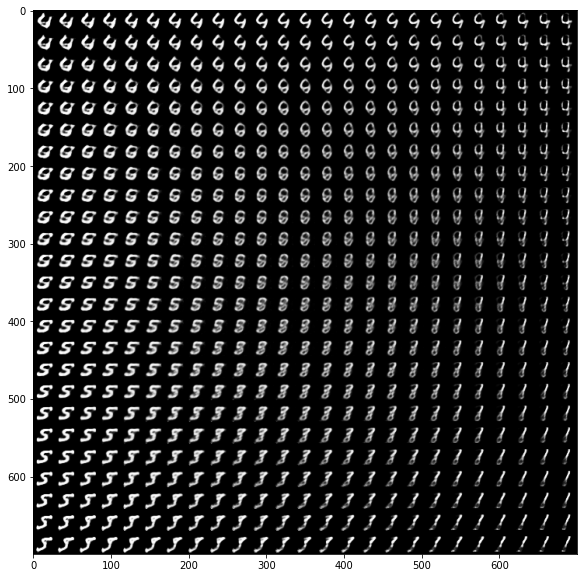

In [ ]:
from scipy.stats import norm

def plot_latent_image(model,latent_dim,patch_count,patch_side_size=28):
  # 3σ
  xs=norm.ppf(np.linspace(0.01,0.99,patch_count))
  ys=norm.ppf(np.linspace(0.01,0.99,patch_count))
  image_size=[patch_count*patch_side_size,patch_count*patch_side_size]
  image=np.zeros(image_size)

  for x_index,x in enumerate(xs):
    for y_index,y in enumerate(ys):
      z=np.tile(np.array([[x,y]]),latent_dim).reshape(-1,latent_dim)
      z=torch.Tensor(z).cuda()
      decoder_image=model.decoder(z)
      decoder_image=decoder_image.reshape(-1,patch_side_size,patch_side_size)[0]
      image[x_index*patch_side_size:(x_index+1)*patch_side_size,y_index*patch_side_size:(y_index+1)*patch_side_size]=decoder_image.cpu().detach().numpy()
  plt.figure(figsize=(10,10))
  plt.imshow(image,cmap="gray")
  plt.show()

model=torch.load("VAE_epoch_180_2021-12-23-06-44-28.pth")
plot_latent_image(model,20,25,28)

## Download from colab

In [ ]:
import os,tarfile,shutil
from google.colab import files

def download(file_path):
  for file in os.listdir(file_path):
    files.download("{}/{}".format(file_path,file))

def download_tar(output_filename, source_dir):
  with tarfile.open(output_filename, mode="w:gz") as tar:
    for root,dir_name,files_list in os.walk(source_dir):
      for file in files_list:
        pathfile = os.path.join(root, file)
        tar.add(pathfile)
    files.download(output_filename)

download_tar("content.tar","/content")

#download("/content/save_model")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>